# **Project summary**

This notebook predicts the **total fuel consumption of vehicle trips** using **covariates such as speed, acceleration, slope, vehicle characteristics, and ambient temperature**. The core of the methodology is our **HIA (Homogeneous Interval Aggregation) approach** — a **temporal aggregation (TA) technique** that dynamically detects homogeneous intervals in the covariates, allowing for variable-length segmentations based on covariate behavior over time.


**Workflow Overview**



*   **Data Preprocessing**
Trip data from multiple experiments is loaded. Trips with long idling gaps are split into separate segments. A new column is added to compute the horizontal distance traveled per second. All trip data is then combined into a clean dataset.



*   **Sub-Trip Division**
Long trips are divided into sub-trips using a gamma distribution, resulting in segments averaging 10 minutes in length (with a range of 7–15 minutes).

*   **Interval Aggregation Strategies**
Functions are defined to support both:


1.   Fixed-length overlapping and non-overlapping intervals
2.   Three variants of HIA, which detect homogeneous intervals of varying lengths


*   **Data Aggregation**
Statistical summaries are computed within each interval using the selected method (e.g., mean, sum, standard deviation).

*   **Train-Test Splitting**
A subject-wise split is applied: one entire trip is held out as the test set, and the remaining trips are used for training and validation using 5-fold cross-validation.

*   **Model Training and Tuning**
A Random Forest regression model is trained and tuned using cross-validation to identify the best hyperparameters for predicting fuel consumption.

*   **Prediction and Evaluation**
The trained model is used to predict the total fuel consumption of the test trip. Evaluation metrics include:

1.   MAE (Mean Absolute Error)
2.   MAPE (Mean Absolute Percentage Error)


Diagnostic plots are also generated, including:

1.   Actual vs. Predicted values
2.   Residuals vs. Predicted values


*   **Exporting Results**
Prediction results (true vs predicted fuel consumption per trip) are saved to a CSV file in Google Drive.

*   **Comparison of Methods**
The entire prediction pipeline is executed using all three HIA variants, as well as benchmark aggregation methods, for performance comparison.

# **System Preparation**

In this section, I set up the environment by connecting to Google Drive for data import and export, and I import the necessary Python packages.

In [1]:
# Check and set computing device (GPU if available, otherwise CPU)
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Suppress warnings to keep output cleaner
import warnings
warnings.filterwarnings("ignore")

# Mount Google Drive to access data and save outputs
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
import random
random.seed(10)

import numpy as np
np.random.seed(10)

# Time and OS utilities
import time
import os
import math

# Data manipulation and math
import pandas as pd

# Scikit-learn: modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    PredictionErrorDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

# XGBoost: gradient boosting model
from xgboost import XGBRegressor

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
%matplotlib inline

# Geographic distance calculations
from geopy import distance

# Statistical tools
from scipy import stats
from scipy.stats import gamma, bootstrap

# For saving/loading models or results
import pickle

# For whitening function
from sklearn.utils import shuffle
from numpy.linalg import eigh

Mounted at /content/drive


# **Raw Data Preparation**

In this section, we read data from different trip experiments, split trips with significant idling gaps into separate trips, add a column to calculate the horizontal distance traveled per second, combine all trip data, and create a final cleaned dataset named data_ICEV_ClassI_dist.

In [ ]:
# ----------------------------------------
# Reading each trip data
# ----------------------------------------

#Class I

data_Chevrolet_Malibu = pd.read_csv("Chevrolet_Malibu_2019_(October_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Chevrolet_Malibu['Trip']='Chevrolet_Malibu'

data_Ford_Escape1 = pd.read_csv("Ford_Escape_2006_(August_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Escape1['Trip']='Ford_Escape1'

data_Ford_Escape2 = pd.read_csv("Ford_Escape_2006_(January_2020).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Escape2['Trip']='Ford_Escape2'

data_Ford_Escape3 = pd.read_csv("Ford_Escape_2006_(July_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Escape3['Trip']='Ford_Escape3'

data_Ford_Escape4 = pd.read_csv("Ford_Escape_2006_(October_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Escape4['Trip']='Ford_Escape4'

data_Ford_Escape5 = pd.read_csv("Ford_Escape_2006_(September_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Escape5['Trip']='Ford_Escape5'

data_Ford_Focus = pd.read_csv("Ford_Focus_2012_(July_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Focus['Trip']='Ford_Focus'

data_Honda_Civic = pd.read_csv("Honda_Civic_2014_(November_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Honda_Civic['Trip']='Honda_Civic'

data_Honda_Fit = pd.read_csv("Honda_Fit_2009_(November_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Honda_Fit['Trip']='Honda_Fit'

data_Jeep_Patriot = pd.read_csv("Jeep_Patriot_2010_(September_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Jeep_Patriot['Trip']='Jeep_Patriot'

data_Kia_Optima = pd.read_csv("Kia_Optima_2012_(October_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Kia_Optima['Trip']='Kia_Optima'

data_Kia_Rio = pd.read_csv("Kia_Rio_2013_(September_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Kia_Rio['Trip']='Kia_Rio'

data_Mazda_3 = pd.read_csv("Mazda_3_2016_(July_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Mazda_3['Trip']='Mazda_3'

data_Mazda_6 = pd.read_csv("Mazda_6_2009_(November_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Mazda_6['Trip']='data_Mazda_6'

data_Mazda_CX = pd.read_csv("Mazda_CX-3_2019_(January_2020).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Mazda_CX['Trip']='Mazda_CX'

data_Nissan_Micra = pd.read_csv("Nissan_Micra_2019_(November_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Nissan_Micra['Trip']='Nissan_Micra'

data_Nissan_Rouge = pd.read_csv("Nissan_Rouge_2020_(December_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Nissan_Rouge['Trip']='Nissan_Rouge'

data_Toyota_Corolla = pd.read_csv("Toyota_Corolla_2019_(August_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Toyota_Corolla['Trip']='Toyota_Corolla'

data_Toyota_RAV4 = pd.read_csv("Toyota_RAV4_2016_(July_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Toyota_RAV4['Trip']='Toyota_RAV4'

data_Toyota_Rav4_2 = pd.read_csv("Toyota_Rav4_(181024).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Toyota_Rav4_2['Trip']='Toyota_Rav4_2'

data_Toyota_Yaris = pd.read_csv("Toyota_Yaris_2015_(September_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Toyota_Yaris['Trip']='Toyota_Yaris'

data_Volkswagen_Jetta = pd.read_csv("Volkswagen_Jetta_2016_(August_2019).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Volkswagen_Jetta['Trip']='Volkswagen_Jetta'

#Class II

data_Ford_Transit2 = pd.read_csv("Ford_Transit_(050624).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Transit2 ['Trip']='Ford_Transit2'

data_Ford_Transit4 = pd.read_csv("Ford_Transit_(270824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Transit4 ['Trip']='Ford_Transit4'

data_Ford_Transit5 = pd.read_csv("Ford_Transit_250_2023_(July_2023).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Ford_Transit5 ['Trip']='Ford_Transit5'

data_GMC_Savana1 = pd.read_csv("GMC_Savana_(080724).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_GMC_Savana1 ['Trip']='GMC_Savana1'

data_GMC_Savana2 = pd.read_csv("GMC_Savana_(080824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_GMC_Savana2 ['Trip']='GMC_Savana2'

data_GMC_Savana3 = pd.read_csv("GMC_Savana_(220824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_GMC_Savana3 ['Trip']='GMC_Savana3'

data_GMC_Savana4 = pd.read_csv("GMC_Savana_2023_(July_2023).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_GMC_Savana4 ['Trip']='GMC_Savana4'

data_Silverado1 = pd.read_csv("Silverado_1500_(140824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Silverado1 ['Trip']='Silverado1'

data_Silverado2 = pd.read_csv("Silverado_1500_(160824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Silverado2 ['Trip']='Silverado2'

data_Silverado3 = pd.read_csv("Silverado_1500_(230824).csv", parse_dates=["DateTime"], index_col=["DateTime"])
data_Silverado3 ['Trip']='Silverado3'



FileNotFoundError: [Errno 2] No such file or directory: 'Chevrolet_Malibu_2019_(October_2019).csv'

In [ ]:
# ----------------------------------------
# divide trips with missing periods into 2 trips
# ----------------------------------------

data_Ford_Escape1_part1 = data_Ford_Escape1[data_Ford_Escape1.index < '2019-08-21 12:46:14']
data_Ford_Escape1_part1['Trip']= 'Ford_Escape1_part1'
data_Ford_Escape1_part2 = data_Ford_Escape1[data_Ford_Escape1.index > '2019-08-21 12:46:14']
data_Ford_Escape1_part2['Trip']= 'Ford_Escape1_part2'

data_Ford_Focus_part1 = data_Ford_Focus[data_Ford_Focus.index < '2019-07-02 17:02:56']
data_Ford_Focus_part1['Trip']= 'Ford_Focus_part1'
data_Ford_Focus_part2 = data_Ford_Focus[data_Ford_Focus.index > '2019-07-02 17:02:56']
data_Ford_Focus_part2['Trip']= 'Ford_Focus_part2'

data_Toyota_Corolla_part1 = data_Toyota_Corolla[data_Toyota_Corolla.index < '2019-08-26 12:41:51']
data_Toyota_Corolla_part1['Trip']= 'Toyota_Corolla_part1'
data_Toyota_Corolla_part2 = data_Toyota_Corolla[data_Toyota_Corolla.index > '2019-08-26 12:41:51']
data_Toyota_Corolla_part2['Trip']= 'Toyota_Corolla_part2'

data_Toyota_Yaris_part1 = data_Toyota_Yaris[data_Toyota_Yaris.index < '2019-09-05 13:14:19']
data_Toyota_Yaris_part1['Trip']= 'Toyota_Yaris_part1'
data_Toyota_Yaris_part2 = data_Toyota_Yaris[data_Toyota_Yaris.index > '2019-09-05 13:14:19']
data_Toyota_Yaris_part2['Trip']= 'Toyota_Yaris_part2'

data_Volkswagen_Jetta_part1 = data_Volkswagen_Jetta[data_Volkswagen_Jetta.index < '2019-08-02 17:38:43']
data_Volkswagen_Jetta_part1['Trip']= 'Volkswagen_Jetta_part1'
data_Volkswagen_Jetta_part2 = data_Volkswagen_Jetta[data_Volkswagen_Jetta.index > '2019-08-02 17:38:43']
data_Volkswagen_Jetta_part2['Trip']= 'Volkswagen_Jetta_part2'

In [ ]:
# ----------------------------------------
#visualize a sample trip data
# ----------------------------------------

data=data_Mazda_3                   ### change it to the trip you wish to visualize
fig, ax = plt.subplots()
ax.plot(data.index, data["Fuel Rate2 [g.s-1]"]);      ### you may chose another variable like acceleration, slope, speed to be visualized
ax.set_xlabel("Time");
ax.set_ylabel("Fuel Consumption Rate");               ### can change based on teh variable you choose to visualize
plt.show()


In [ ]:
# ----------------------------------------
## Function to calculate horizontal distance (in meters) between sequential GPS points in a DataFrame
# ----------------------------------------

from geopy import distance

def distance_seq(df):
    """
    Calculates the horizontal (2D) distance in meters between sequential GPS coordinates.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns 'Latitude [deg]' and 'Longitude [deg]'

    Returns:
        df (pd.DataFrame): Same DataFrame with an added 'distance' column (meters between each pair of rows)
    """
    # Extract GPS coordinates as tuples (lat, lon)
    coords = df[['Latitude [deg]', 'Longitude [deg]']].apply(tuple, axis=1)

    # Initialize distance column with zeros
    distances = np.zeros(len(coords))

    # Calculate distance between each pair of consecutive coordinates
    for i in range(1, len(coords)):
        distances[i] = distance.distance(coords[i - 1], coords[i]).m  # in meters

    # Assign to DataFrame
    df['Distance'] = distances

    return df


In [ ]:
# ----------------------------------------
# For each trip we add two columns
# 1. a column for sequential horizontal distances (Distance)
# 2. a column to show the row number (Seconds)
# ----------------------------------------

data_Chevrolet_Malibu = distance_seq(data_Chevrolet_Malibu)
rows = len(data_Chevrolet_Malibu)
data_Chevrolet_Malibu['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape1_part1 = distance_seq(data_Ford_Escape1_part1)
rows = len(data_Ford_Escape1_part1)
data_Ford_Escape1_part1['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape1_part2 = distance_seq(data_Ford_Escape1_part2)
rows = len(data_Ford_Escape1_part2)
data_Ford_Escape1_part2['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape2 = distance_seq(data_Ford_Escape2)
rows = len(data_Ford_Escape2)
data_Ford_Escape2['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape3 = distance_seq(data_Ford_Escape3)
rows = len(data_Ford_Escape3)
data_Ford_Escape3['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape4 = distance_seq(data_Ford_Escape4)
rows = len(data_Ford_Escape4)
data_Ford_Escape4['Seconds'] = np.arange(1, rows + 1)

data_Ford_Escape5 = distance_seq(data_Ford_Escape5)
rows = len(data_Ford_Escape5)
data_Ford_Escape5['Seconds'] = np.arange(1, rows + 1)

data_Ford_Focus_part1 = distance_seq(data_Ford_Focus_part1)
rows = len(data_Ford_Focus_part1)
data_Ford_Focus_part1['Seconds'] = np.arange(1, rows + 1)

data_Ford_Focus_part2 = distance_seq(data_Ford_Focus_part2)
rows = len(data_Ford_Focus_part2)
data_Ford_Focus_part2['Seconds'] = np.arange(1, rows + 1)

data_Ford_Transit2 = distance_seq(data_Ford_Transit2)
rows = len(data_Ford_Transit2)
data_Ford_Transit2['Seconds'] = np.arange(1, rows + 1)

data_Ford_Transit4 = distance_seq(data_Ford_Transit4)
rows = len(data_Ford_Transit4)
data_Ford_Transit4['Seconds'] = np.arange(1, rows + 1)

data_Ford_Transit5 = distance_seq(data_Ford_Transit5)
rows = len(data_Ford_Transit5)
data_Ford_Transit5['Seconds'] = np.arange(1, rows + 1)

data_GMC_Savana1 = distance_seq(data_GMC_Savana1)
rows = len(data_GMC_Savana1)
data_GMC_Savana1['Seconds'] = np.arange(1, rows + 1)

data_GMC_Savana2 = distance_seq(data_GMC_Savana2)
rows = len(data_GMC_Savana2)
data_GMC_Savana2['Seconds'] = np.arange(1, rows + 1)

data_GMC_Savana3 = distance_seq(data_GMC_Savana3)
rows = len(data_GMC_Savana3)
data_GMC_Savana3['Seconds'] = np.arange(1, rows + 1)

data_GMC_Savana4 = distance_seq(data_GMC_Savana4)
rows = len(data_GMC_Savana4)
data_GMC_Savana4['Seconds'] = np.arange(1, rows + 1)

data_Honda_Civic = distance_seq(data_Honda_Civic)
rows = len(data_Honda_Civic)
data_Honda_Civic['Seconds'] = np.arange(1, rows + 1)

data_Honda_Fit = distance_seq(data_Honda_Fit)
rows = len(data_Honda_Fit)
data_Honda_Fit['Seconds'] = np.arange(1, rows + 1)

data_Jeep_Patriot = distance_seq(data_Jeep_Patriot)
rows = len(data_Jeep_Patriot)
data_Jeep_Patriot['Seconds'] = np.arange(1, rows + 1)

data_Kia_Optima = distance_seq(data_Kia_Optima)
rows = len(data_Kia_Optima)
data_Kia_Optima['Seconds'] = np.arange(1, rows + 1)

data_Kia_Rio = distance_seq(data_Kia_Rio)
rows = len(data_Kia_Rio)
data_Kia_Rio['Seconds'] = np.arange(1, rows + 1)

data_Mazda_3 = distance_seq(data_Mazda_3)
rows = len(data_Mazda_3)
data_Mazda_3['Seconds'] = np.arange(1, rows + 1)

data_Mazda_6 = distance_seq(data_Mazda_6)
rows = len(data_Mazda_6)
data_Mazda_6['Seconds'] = np.arange(1, rows + 1)

data_Mazda_CX = distance_seq(data_Mazda_CX)
rows = len(data_Mazda_CX)
data_Mazda_CX['Seconds'] = np.arange(1, rows + 1)

data_Nissan_Micra = distance_seq(data_Nissan_Micra)
rows = len(data_Nissan_Micra)
data_Nissan_Micra['Seconds'] = np.arange(1, rows + 1)

data_Nissan_Rouge = distance_seq(data_Nissan_Rouge)
rows = len(data_Nissan_Rouge)
data_Nissan_Rouge['Seconds'] = np.arange(1, rows + 1)

data_Silverado1 = distance_seq(data_Silverado1)
rows = len(data_Silverado1)
data_Silverado1['Seconds'] = np.arange(1, rows + 1)

data_Silverado2 = distance_seq(data_Silverado2)
rows = len(data_Silverado2)
data_Silverado2['Seconds'] = np.arange(1, rows + 1)

data_Silverado3 = distance_seq(data_Silverado3)
rows = len(data_Silverado3)
data_Silverado3['Seconds'] = np.arange(1, rows + 1)

data_Toyota_Corolla_part1 = distance_seq(data_Toyota_Corolla_part1)
rows = len(data_Toyota_Corolla_part1)
data_Toyota_Corolla_part1['Seconds'] = np.arange(1, rows + 1)

data_Toyota_Corolla_part2 = distance_seq(data_Toyota_Corolla_part2)
rows = len(data_Toyota_Corolla_part2)
data_Toyota_Corolla_part2['Seconds'] = np.arange(1, rows + 1)

data_Toyota_RAV4 = distance_seq(data_Toyota_RAV4)
rows = len(data_Toyota_RAV4)
data_Toyota_RAV4['Seconds'] = np.arange(1, rows + 1)

data_Toyota_Rav4_2 = distance_seq(data_Toyota_Rav4_2)
rows = len(data_Toyota_Rav4_2)
data_Toyota_Rav4_2['Seconds'] = np.arange(1, rows + 1)

data_Toyota_Yaris_part1 = distance_seq(data_Toyota_Yaris_part1)
rows = len(data_Toyota_Yaris_part1)
data_Toyota_Yaris_part1['Seconds'] = np.arange(1, rows + 1)

data_Toyota_Yaris_part2 = distance_seq(data_Toyota_Yaris_part2)
rows = len(data_Toyota_Yaris_part2)
data_Toyota_Yaris_part2['Seconds'] = np.arange(1, rows + 1)

data_Volkswagen_Jetta_part1 = distance_seq(data_Volkswagen_Jetta_part1)
rows = len(data_Volkswagen_Jetta_part1)
data_Volkswagen_Jetta_part1['Seconds'] = np.arange(1, rows + 1)

data_Volkswagen_Jetta_part2 = distance_seq(data_Volkswagen_Jetta_part2)
rows = len(data_Volkswagen_Jetta_part2)
data_Volkswagen_Jetta_part2['Seconds'] = np.arange(1, rows + 1)


In [ ]:
# ----------------------------------------
# concat all trips' sets
# ----------------------------------------

data_ICEV_ClassI_dist = pd.concat([

    data_Chevrolet_Malibu,
    data_Ford_Escape1_part1,
    data_Ford_Escape1_part2,
    data_Ford_Escape2,
    data_Ford_Escape3,
    data_Ford_Escape4,
    data_Ford_Escape5,
    data_Ford_Focus_part1,
    data_Ford_Focus_part2,
    data_Ford_Transit2,
    data_Ford_Transit4,
    data_Ford_Transit5,
    data_GMC_Savana1,
    data_GMC_Savana2,
    data_GMC_Savana3,
    data_GMC_Savana4,
    data_Honda_Civic,
    data_Honda_Fit,
    data_Jeep_Patriot,
    data_Kia_Optima,
    data_Kia_Rio,
    data_Mazda_3,
    data_Mazda_6,
    data_Mazda_CX,
    data_Nissan_Micra,
    data_Nissan_Rouge,
    data_Silverado1,
    data_Silverado2,
    data_Silverado3,
    data_Toyota_Corolla_part1,
    data_Toyota_Corolla_part2,
    data_Toyota_RAV4,
    data_Toyota_Rav4_2,
    data_Toyota_Yaris_part1,
    data_Toyota_Yaris_part2,
    data_Volkswagen_Jetta_part1,
    data_Volkswagen_Jetta_part2

])

# ----------------------------------------
# Adding "Duration" column to teh data. It is always equal to 1 which is the 1 second frequency of the data
# ----------------------------------------

data_ICEV_ClassI_dist['Duration']=1

data_ICEV_ClassI_dist.shape



In [ ]:
# ----------------------------------------
# renaming some columns for easier use
# ----------------------------------------

data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Engine Speed [rpm]': 'EngineSpeed'})
data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Vehicle Speed [km.h-1]': 'VehicleSpeed'})
data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Acceleration [m.s-2]': 'Acceleration'})
data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Slope [%]': 'Slope'})
data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Avg Ambient Air Temperature [c]': 'Temperature'})
data_ICEV_ClassI_dist = data_ICEV_ClassI_dist.rename(columns={'Fuel Rate2 [g.s-1]': 'FuelRate'})


In [ ]:
# ----------------------------------------
# save data in googledrive to be uploaded and used in the following sections
# ----------------------------------------

data_ICEV_ClassI_dist.to_csv('/content/drive/My Drive/data_ICEV_ClassI_dist.csv', index=False)

# **Trip division**

In this section, we split long trips into sub-trips with durations averaging 10 minutes, ranging between 7 and 15 minutes. This is done using a gamma distribution, from which we randomly sample sub-trip lengths with a mean of 10 minutes.

In [ ]:
## We use a Gamma distribution to simulate the durations of sub-trips when splitting long vehicle trips into shorter segments. The distribution is centered around a mean of 600 seconds (10 minutes) with a shape parameter of 4. This ensures sub-trips are realistic and variable, yet mostly within 7 to 15 minutes in length.

##The plot below shows the probability density function (PDF) of the Gamma distribution used, with vertical lines at:
##- **7 minutes (420s)**: minimum cutoff
##- **10 minutes (600s)**: mean
##- **15 minutes (900s)**: maximum cutoff

# ----------------------------------------
# Plotting the Gamma Distribution for Sub-Trip Durations
# ----------------------------------------

from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the Gamma distribution
shape = 4
mean = 600  # 10 minutes in seconds
scale = mean / shape  # Gamma scale = mean / shape

# Generate values for the x-axis: 0 to 1200 seconds (i.e., up to 20 minutes)
x = np.linspace(0, 1200, 1000)
y = gamma.pdf(x, a=shape, scale=scale)

# Plot the Gamma probability density function (PDF)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Gamma PDF')

# Add vertical lines for min, mean, and max thresholds
plt.axvline(420, color='red', linestyle='--')    # 7 minutes
plt.axvline(600, color='green', linestyle='--')  # 10 minutes (mean)
plt.axvline(900, color='orange', linestyle='--') # 15 minutes

# Add legend to describe the lines
plt.legend(
    ['Gamma PDF', 'Min (7 min)', 'Mean (10 min)', 'Max (15 min)'],
    loc='upper right'
)

# Add axis labels and title
plt.title("Gamma Distribution for Simulated Sub-Trip Durations")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Probability Density")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## This function splits long trips into shorter sub-trips using durations sampled from a Gamma distribution with:
## - Mean = 10 minutes (600 seconds)
## - Minimum = 7 minutes (420 seconds)
## - Maximum = 15 minutes (900 seconds)
##
## Each sub-trip is labeled with a unique ID (e.g., `TripA_1`, `TripA_2`) and contains a row counter (`row_in_sub_trip`)
## that can be used for further time-based modeling. This segmentation helps create a dataset of shorter,
## realistic driving segments for modeling total fuel consumption.

# --------------------------------------------------------
# Function: divide_trips_into_subtrips
# --------------------------------------------------------

def divide_trips_into_subtrips(df):
    """
    Splits each full vehicle trip into shorter sub-trips using durations sampled
    from a Gamma distribution centered around 10 minutes (600 seconds).

    Each sub-trip will have a duration between 7 and 15 minutes (420 to 900 seconds),
    except possibly the last one, which may be merged or adjusted for length.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a 'Trip' column (trip ID) and rows representing per-second data.

    Returns:
        pd.DataFrame: Modified DataFrame with new columns:
            - 'sub_trip': unique sub-trip identifier (e.g., "TripA_1")
            - 'row_in_sub_trip': row number within the sub-trip (starts at 1)
    """

    # Constants for duration thresholds
    SECONDS_PER_MINUTE = 60
    MIN_LEN = 7 * SECONDS_PER_MINUTE   # Minimum sub-trip duration (420s)
    MAX_LEN = 15 * SECONDS_PER_MINUTE  # Maximum sub-trip duration (900s)
    MEAN_LEN = 10 * SECONDS_PER_MINUTE # Desired average (600s)

    # Gamma distribution parameters
    shape = 4.0
    scale = MEAN_LEN / shape  # Ensures mean = shape * scale

    # Check for required column
    if 'Trip' not in df.columns:
        raise ValueError("Input DataFrame must contain a 'Trip' column.")

    # Ensure 'Trip' column is string
    df = df.copy()
    df['Trip'] = df['Trip'].astype(str)

    all_chunks = []

    # Process each trip independently
    for trip_id in df['Trip'].unique():
        trip_data = df[df['Trip'] == trip_id].copy().reset_index(drop=True)
        total_len = len(trip_data)
        start = 0
        segments = []

        # 1. Divide the trip into segments with durations sampled from Gamma distribution
        while start < total_len:
            if total_len - start <= MAX_LEN:
                end = total_len  # Last segment
            else:
                # Draw a valid duration within [MIN_LEN, MAX_LEN]
                while True:
                    length = int(np.random.gamma(shape, scale))
                    if MIN_LEN <= length <= MAX_LEN:
                        break
                end = min(start + length, total_len)

            segments.append((start, end))
            start = end

        # 2. Post-process last segment if it's too short
        if len(segments) >= 2:
            last_start, last_end = segments[-1]
            last_length = last_end - last_start

            if last_length < MIN_LEN:
                # Merge last short segment with previous one
                prev_start, prev_end = segments[-2]
                merged_start = prev_start
                merged_end = last_end
                merged_length = merged_end - merged_start

                segments = segments[:-2]  # Remove last two
                # If merged segment is too long, split into two halves
                if merged_length > MAX_LEN:
                    mid = merged_start + merged_length // 2
                    segments.append((merged_start, mid))
                    segments.append((mid, merged_end))
                else:
                    segments.append((merged_start, merged_end))

        # 3. Label sub-trips and number rows within each
        sub_trip_counter = 1
        for seg_start, seg_end in segments:
            sub_trip_id = f"{trip_id}_{sub_trip_counter}"
            rows_in_segment = seg_end - seg_start

            trip_data.loc[seg_start:seg_end - 1, 'sub_trip'] = sub_trip_id
            trip_data.loc[seg_start:seg_end - 1, 'row_in_sub_trip'] = np.arange(1, rows_in_segment + 1)
            sub_trip_counter += 1

        # Ensure 'row_in_sub_trip' is stored as integer
        trip_data['row_in_sub_trip'] = trip_data['row_in_sub_trip'].astype('Int64')

        all_chunks.append(trip_data)

    # Combine all sub-trip segments into a single DataFrame
    return pd.concat(all_chunks, ignore_index=True)




In [ ]:
# --------------------------------------------------------
# import data of all trips that we prepared in "Raw Data Preparation" section
# --------------------------------------------------------

data = pd.read_csv("data_ICEV_ClassI_dist.csv")

# --------------------------------------------------------
# we divide the trips into subtrips using the "divide_trips_into_subtrips" function
# --------------------------------------------------------

final_df=divide_trips_into_subtrips(data)

# --------------------------------------------------------
# upload subtrip data to googledrive to be used later in the following sections
# --------------------------------------------------------

final_df.to_csv('/content/drive/My Drive/data_subtrip.csv', index=False)

final_df.head()

In [ ]:
## After dividing trips into sub-trips, we summarize their duration distribution.
## Each sub-trip is treated as a sequence of 1-second rows. This function calculates:
## - Total number of sub-trips
## - Average sub-trip length
## - 25th and 75th percentiles

## All durations are reported in **minutes** for interpretability.

# --------------------------------------------------------
# Function: Some stats on sub-trips
# --------------------------------------------------------

def summarize_subtrip_lengths(df):
    """
    Summarizes the distribution of sub-trip durations in the dataset.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing a 'sub_trip' column.
                           Each row is assumed to represent 1 second of a trip.

    Returns:
        dict: A summary with:
            - Total number of sub-trips
            - Average duration (in minutes)
            - 25th percentile of duration (in minutes)
            - 75th percentile of duration (in minutes)
    """
    if 'sub_trip' not in df.columns:
        raise ValueError("DataFrame must contain a 'sub_trip' column.")

    # Get sub-trip durations (in seconds), one row = one second
    subtrip_lengths = df.groupby('sub_trip').size()

    # Convert durations to minutes for easier interpretation
    avg_length_min = subtrip_lengths.mean() / 60
    p25_min = subtrip_lengths.quantile(0.25) / 60
    p75_min = subtrip_lengths.quantile(0.75) / 60

    summary = {
        'Total Sub-Trips': len(subtrip_lengths),
        'Average Length (min)': round(avg_length_min),
        '25th Percentile (min)': round(p25_min),
        '75th Percentile (min)': round(p75_min)
    }

    return summary

# Example usage
summary = summarize_subtrip_lengths(final_df)
print(summary)



In [ ]:
## We visualize the distribution of sub-trip durations to confirm that the splitting process aligns with our target range of 7–15 minutes. Two plots are used:
## 1. Histogram of continuous sub-trip durations (in minutes), showing the full distribution.
## 2. Bar chart of discrete, rounded durations, grouped into 1-minute bins for easier interpretation.
## This step helps validate the effectiveness of our Gamma-based trip segmentation strategy.

import matplotlib.pyplot as plt

# --------------------------------------------------------
# Function: plot_subtrip_length_histogram
# --------------------------------------------------------
# Purpose:
# Plots a histogram showing how long sub-trips are, in minutes.
# Useful to see whether most sub-trips fall within the 7–15 minute target.
def plot_subtrip_length_histogram(df):
    """
    Plots a histogram of sub-trip durations in minutes.

    Parameters:
        df (pd.DataFrame): Must contain a 'sub_trip' column.
                           Each row is assumed to represent one second.
    """
    if 'sub_trip' not in df.columns:
        raise ValueError("DataFrame must contain a 'sub_trip' column.")

    # Get sub-trip durations in seconds and convert to minutes
    subtrip_lengths_sec = df.groupby('sub_trip').size()
    subtrip_lengths_min = subtrip_lengths_sec / 60

    # Plot the histogram with 10 bins
    plt.figure(figsize=(10, 6))
    plt.hist(subtrip_lengths_min, bins=10, edgecolor='black')
    plt.title("Histogram of Sub-Trip Lengths (in minutes)")
    plt.xlabel("Sub-Trip Duration (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------
# Usage Example: Show distribution of sub-trip lengths
# --------------------------------------------------------
final_df = pd.read_csv("data_subtrip.csv")
plot_subtrip_length_histogram(final_df)



# **Overlapping and non overlapping interval summarization functions**

In this section, we define functions to identify and summarize overlapping and non-overlapping intervals of fixed length.

In [2]:
# --------------------------------------------------------
# Function: summation_non_overlapping
# --------------------------------------------------------
# This function performs non-overlapping temporal aggregation over a time-series DataFrame.
# It segments the data into intervals of a specified size (in terms of a variable like 'time' or 'distance'),
# and computes statistical summaries (mean, sum, std, etc.) over each interval.
#
# If the final segment does not fully complete the interval, it is kept as an "incomplete" aggregation
# and can be used for predicting the final segment of a trip.

#non_Overlapping variable (duration/distance) aggregation function
# the last period is the remaining of dividion of data into intervals. this will be used for prediction of the entire trip.

"""
    Aggregate functional and scalar features over non-overlapping intervals.

    Parameters:
    - df: pandas DataFrame containing data for a single subject or trip.
    - interval_size: Size of each aggregation interval. If < 1, treated as a fraction of total data length.
    - X_functional: List of functional (time-varying) variable names to summarize.
    - X_common_summary_list: List of summary statistics (e.g., 'mean', 'std', 'sum') to apply to all X_functional variables.
    - X_scalar: List of scalar (non-time-varying) variable names to summarize with their default summary.
    - X_specific_summary_list: List of (variable_name, summary_function) pairs for variable-specific summaries.
    - y: Name of the target variable.
    - y_type: Type of the target variable; either "functional" (aggregated like functional predictors) or "scalar".
    - y_summary: Summary function to apply to the target if it is functional (e.g., 'mean', 'sum').
    - aggregation_var: Variable used to accumulate data within an interval (e.g., "duration", "delta_time").

    Returns:
    - new_df: DataFrame with aggregated summaries over non-overlapping intervals, including aggregation metadata:
        - 'agg_size': actual sum of aggregation_var in the interval
        - 'agg_level': expected interval size
        - 'agg_type': "complete" or "incomplete" depending on whether the interval reached full size
        - 'agg_method': always "non_overlapping"
"""


def summation_non_overlapping(df,
                              interval_size,
                              X_functional,
                              X_common_summary_list,
                              X_scalar,
                              X_specific_summary_list,
                              y,
                              y_type,
                              y_summary,
                              aggregation_var):
  new_df = df
  if interval_size > df[aggregation_var].sum():
    print("WARNING: interval is bigger than the data size")
  elif interval_size == 1:
    print("WARNING: interval size must be an integer greater or equal to 2.")
  else:
    if interval_size<1:
      interval_size=math.floor(interval_size*(len(df)))
      step_size=math.floor(interval_size*0.1)
    counter=0
    while counter <= len(new_df)-1:
      sum=0
      i=0
      temps = new_df.iloc[:0,:].copy()
      while (sum<interval_size) and (counter+i<= len(new_df)-1):
        sum=sum+new_df[aggregation_var].iloc[counter+i]
        row_by_position = new_df.iloc[[counter+i]]
        temps=pd.concat([temps, row_by_position])
        i=i+1
      for variable in X_functional:
        temp=temps[variable].tolist()
        for summary in X_common_summary_list:
          text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
          if summary=='mean':
            new_df.at[counter,text]=np.sum(temp)/sum
          elif summary=='sum':
            new_df.at[counter,text]=np.sum(temp)
          elif summary=='std':
            new_df.at[counter,text]=np.std(temp)
          elif summary=='var':
            new_df.at[counter,text]=np.var(temp)
          elif summary=='min':
            new_df.at[counter,text]=np.min(temp)
          elif summary=='max':
            new_df.at[counter,text]=np.max(temp)
          elif summary=='median':
            new_df.at[counter,text]=np.median(temp)
          elif summary=='range':
            new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
          elif summary=='mode':
            new_df.at[counter,text]=stats.mode(temp)
          elif summary=='meanabs':
            new_df.at[counter,text]=np.sum(np.abs(temp))/sum
          elif summary=='zero_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
          elif summary=='positive_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
          else:
            print("summary ",summary, " is not supported")

      for variable in X_scalar:
        temp=temps[variable].tolist()
        summary = "mean"
        text=summary+"_"+variable
        new_df.at[counter,text]=np.sum(temp)/sum

      if len(X_specific_summary_list)>0:
        for j in range(len(X_specific_summary_list)):
          variable = X_specific_summary_list[j][0]
          temp=temps[variable].tolist()
          summary = X_specific_summary_list[j][1]
          text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
          if summary=='mean':
            new_df.at[counter,text]=np.sum(temp)/sum
          elif summary=='sum':
            new_df.at[counter,text]=np.sum(temp)
          elif summary=='std':
            new_df.at[counter,text]=np.std(temp)
          elif summary=='var':
            new_df.at[counter,text]=np.var(temp)
          elif summary=='min':
            new_df.at[counter,text]=np.min(temp)
          elif summary=='max':
            new_df.at[counter,text]=np.max(temp)
          elif summary=='median':
            new_df.at[counter,text]=np.median(temp)
          elif summary=='range':
            new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
          elif summary=='mode':
            new_df.at[counter,text]=stats.mode(temp)
          elif summary=='meanabs':
            new_df.at[counter,text]=np.sum(np.abs(temp))/sum
          elif summary=='zero_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
          elif summary=='positive_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
          else:
            print("summary ",summary, " is not supported")

      if y_type == "functional":
        variable=y
        temp=temps[variable].tolist()
        summary=y_summary
        text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
        if summary=='mean':
          new_df.at[counter,text]=np.sum(temp)/sum
        elif summary=='sum':
          new_df.at[counter,text]=np.sum(temp)
        elif summary=='std':
          new_df.at[counter,text]=np.std(temp)
        elif summary=='var':
          new_df.at[counter,text]=np.var(temp)
        elif summary=='min':
          new_df.at[counter,text]=np.min(temp)
        elif summary=='max':
          new_df.at[counter,text]=np.max(temp)
        elif summary=='median':
          new_df.at[counter,text]=np.median(temp)
        elif summary=='range':
          new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
        elif summary=='mode':
          new_df.at[counter,text]=stats.mode(temp)
        elif summary=='meanabs':
          new_df.at[counter,text]=np.sum(np.abs(temp))/sum
        elif summary=='zero_portion':
          new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
        elif summary=='positive_portion':
          new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
        else:
          print("summary ",summary, " is not supported")

      else:
        variable=y
        temp=temps[variable].tolist()
        summary = "mean"
        text=summary+"_"+variable
        new_df.at[counter,text]=np.sum(temp)/sum

      if sum <interval_size:
        new_df.at[counter,"agg_size"] = sum
        new_df.at[counter,"agg_level"] = interval_size
        new_df.at[counter,"agg_type"] = "incomplete"
        new_df.at[counter,"agg_method"] = "non_overlapping"
        counter=len(new_df)
      else:
        new_df.at[counter,"agg_size"] = sum
        new_df.at[counter,"agg_level"] = interval_size
        new_df.at[counter,"agg_type"] = "complete"
        new_df.at[counter,"agg_method"] = "non_overlapping"
        counter=counter+i

    new_df=new_df[(new_df["agg_type"] == "complete") | (new_df["agg_type"] == "incomplete")]
    new_df=new_df.reset_index(drop=True)
  return new_df




In [3]:
# --------------------------------------------------------
# Function: summation_overlapping
# --------------------------------------------------------
# Overlapping Temporal Aggregation Function
#
# This function performs overlapping temporal aggregation over a time-series DataFrame.
# It moves a sliding window (of specified `interval_size`) across the data in steps of `step_size`,
# computing statistical summaries (e.g., mean, sum, std) over each window.
#
# If the last segment is shorter than the interval, it is treated as an incomplete window
# and can optionally be used for end-of-trip prediction.
#
# The output contains a subset of rows annotated with summary features and aggregation metadata.
# --------------------------------------------------------

"""
    Aggregate functional and scalar features over overlapping intervals.

    Parameters:
    - df: pandas DataFrame containing data for a single subject or trip.
    - interval_size: Size of each aggregation interval. If < 1, treated as a fraction of total data length.
    - X_functional: List of functional (time-varying) variable names to summarize.
    - X_common_summary_list: List of summary statistics (e.g., 'mean', 'std', 'sum') applied to all X_functional variables.
    - X_scalar: List of scalar (non-time-varying) variable names summarized using their default summary (mean).
    - X_specific_summary_list: List of (variable_name, summary_function) tuples for variable-specific summaries.
    - y: Name of the target variable.
    - y_type: Type of the target variable; either "functional" or "scalar".
    - y_summary: Summary function applied to the target if it is functional (e.g., 'mean', 'sum').
    - aggregation_var: Variable used to accumulate values within an interval (e.g., time duration or distance).
    - step_size: Step size between consecutive overlapping intervals, measured in row increments.

    Returns:
    - new_df: DataFrame containing aggregated summaries over overlapping intervals, including:
        - 'agg_size': actual sum of aggregation_var within the interval
        - 'agg_level': target interval size
        - 'agg_type': always "complete" (incomplete intervals are discarded)
        - 'agg_method': always "overlapping"
"""

def summation_overlapping(df,
                          interval_size,
                          X_functional,
                          X_common_summary_list,
                          X_scalar,
                          X_specific_summary_list,
                          y,
                          y_type,
                          y_summary,
                          aggregation_var,
                          step_size):
  new_df = df
  if interval_size > df[aggregation_var].sum():
    print("WARNING: interval is bigger than the data size")
  elif interval_size == 1:
    print("WARNING: interval size must be an integer greater or equal to 2." )
  elif interval_size == 1:
    print("WARNING: step size must be an integer greater or equal to 1." )
  else:
    if interval_size<1:
      interval_size=math.floor(interval_size*(len(df)))
      step_size=math.floor(interval_size*0.1)
    counter=0
    while counter <= len(new_df)-1:
      sum=0
      i=0
      temps = new_df.iloc[:0,:].copy()
      while (sum<interval_size) and (counter+i<= len(new_df)-1):
        sum=sum+new_df[aggregation_var].iloc[counter+i]
        row_by_position = new_df.iloc[[counter+i]]
        temps=pd.concat([temps, row_by_position])
        i=i+1
      for variable in X_functional:
        temp=temps[variable].tolist()
        for summary in X_common_summary_list:
          text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
          if summary=='mean':
            new_df.at[counter,text]=np.sum(temp)/sum
          elif summary=='sum':
            new_df.at[counter,text]=np.sum(temp)
          elif summary=='std':
            new_df.at[counter,text]=np.std(temp)
          elif summary=='var':
            new_df.at[counter,text]=np.var(temp)
          elif summary=='min':
            new_df.at[counter,text]=np.min(temp)
          elif summary=='max':
            new_df.at[counter,text]=np.max(temp)
          elif summary=='median':
            new_df.at[counter,text]=np.median(temp)
          elif summary=='range':
            new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
          elif summary=='mode':
            new_df.at[counter,text]=stats.mode(temp)
          elif summary=='meanabs':
            new_df.at[counter,text]=np.sum(np.abs(temp))/sum
          elif summary=='zero_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
          elif summary=='positive_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
          else:
            print("summary ",summary, " is not supported")

      for variable in X_scalar:
        temp=temps[variable].tolist()
        summary = "mean"
        text=summary+"_"+variable
        new_df.at[counter,text]=np.sum(temp)/sum

      if len(X_specific_summary_list)>0:
        for j in range(len(X_specific_summary_list)):
          variable = X_specific_summary_list[j][0]
          temp=temps[variable].tolist()
          summary = X_specific_summary_list[j][1]
          text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
          if summary=='mean':
            new_df.at[counter,text]=np.sum(temp)/sum
          elif summary=='sum':
            new_df.at[counter,text]=np.sum(temp)
          elif summary=='std':
            new_df.at[counter,text]=np.std(temp)
          elif summary=='var':
            new_df.at[counter,text]=np.var(temp)
          elif summary=='min':
            new_df.at[counter,text]=np.min(temp)
          elif summary=='max':
            new_df.at[counter,text]=np.max(temp)
          elif summary=='median':
            new_df.at[counter,text]=np.median(temp)
          elif summary=='range':
            new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
          elif summary=='mode':
            new_df.at[counter,text]=stats.mode(temp)
          elif summary=='meanabs':
            new_df.at[counter,text]=np.sum(np.abs(temp))/sum
          elif summary=='zero_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
          elif summary=='positive_portion':
            new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
          else:
            print("summary ",summary, " is not supported")

      if y_type == "functional":
        variable=y
        temp=temps[variable].tolist()
        summary=y_summary
        text=summary+"_"+variable
     # new_df[text]= np.empty(len(df))
        if summary=='mean':
          new_df.at[counter,text]=np.sum(temp)/sum
        elif summary=='sum':
          new_df.at[counter,text]=np.sum(temp)
        elif summary=='std':
          new_df.at[counter,text]=np.std(temp)
        elif summary=='var':
          new_df.at[counter,text]=np.var(temp)
        elif summary=='min':
          new_df.at[counter,text]=np.min(temp)
        elif summary=='max':
          new_df.at[counter,text]=np.max(temp)
        elif summary=='median':
          new_df.at[counter,text]=np.median(temp)
        elif summary=='range':
          new_df.at[counter,text]=np.nanmax(temp) - np.nanmin(temp)
        elif summary=='mode':
          new_df.at[counter,text]=stats.mode(temp)
        elif summary=='meanabs':
          new_df.at[counter,text]=np.sum(np.abs(temp))/sum
        elif summary=='zero_portion':
          new_df.at[counter,text]=len([ele for ele in temp if ele == 0])/(len(temp)+1)
        elif summary=='positive_portion':
          new_df.at[counter,text]=len([ele for ele in temp if ele > 0])/(len(temp)+1)
        else:
          print("summary ",summary, " is not supported")

      else:
        variable=y
        temp=temps[variable].tolist()
        summary = "mean"
        text=summary+"_"+variable
        new_df.at[counter,text]=np.sum(temp)/sum

      if sum <interval_size:
        new_df.at[counter,"agg_size"] = sum
        new_df.at[counter,"agg_level"] = interval_size
        new_df.at[counter,"agg_type"] = "incomplete"
        new_df.at[counter,"agg_method"] = "overlapping"
        counter=len(new_df)
      else:
        new_df.at[counter,"agg_size"] = sum
        new_df.at[counter,"agg_level"] = interval_size
        new_df.at[counter,"agg_type"] = "complete"
        new_df.at[counter,"agg_method"] = "overlapping"
        counter=counter+step_size

    new_df=new_df[new_df["agg_type"] == "complete"]
    new_df=new_df.reset_index(drop=True)
  return new_df








# **Homogenous interval summarization function - for all 3 variants of HIA**

In this section, we define functions to identify and summarize homogeneous intervals of varying lengths. We implement all three variants of HIA (Homogeneous Interval Analysis) and plot sample interval length distributions for each variant.

In [56]:
# --------------------------------------------------------
# Function: whiten_multivariate_targets
# --------------------------------------------------------
# This function performs a whitening transformation on a set of
# multivariate input features (`X_critical`) for each subject
# in the dataset. Whitening is done within each subject using
# their covariance structure and is optionally followed by a
# weighting step that adjusts the transformed features based
# on their importance relative to a target variable (`y_var`).
#
# Importance weights can be computed using one of the following
# effects: correlation, squared correlation, or random forest
# permutation importance, using data from a different subject
# under a randomly selected different parent.
#
# The transformed features (weighted whitened features) are added
# back to the dataset with a "_white" suffix. Optionally, the
# function returns the transformation matrices and metadata
# used for each subject.
#
# Parameters:
# - df: Input DataFrame containing all subjects and features.
# - X_critical: List of feature names to whiten.
# - y_var: Target variable name used for weighting (if applicable).
# - subjects: Column name identifying individual subjects.
# - parent_subjects: Column name identifying parent groups.
# - eps: Small constant to ensure numerical stability during whitening.
# - effect: Type of effect weighting to use ("corr", "corr2", "vimp", or None).
# - gamma: Sharpening factor applied to effect weights.
# - weight_norm: Method for normalizing weights ("sum", "mean", or None).
# - min_weight: Minimum value to clamp weights to.
# - n_estimators: Number of trees for random forest (if `effect="vimp"`).
# - random_state: Seed for reproducibility.
# - return_transform: If True, also return whitening and weighting matrices.
#
# Returns:
# - df_out: A copy of the original DataFrame with whitened (and optionally weighted)
#           features appended as new columns.
# - transforms (optional): Dictionary of transformation metadata per subject,
#                          returned only if `return_transform=True`.


from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from numpy.linalg import eigh


def whiten_multivariate_targets(
    df,
    X_critical,
    y_var,
    subjects,
    parent_subjects,
    eps=1e-6,
    effect="corr2",   ## None, "corr", "corr2", "vimp"
    gamma=1.0,
    weight_norm="sum",
    min_weight=1e-8,
    n_estimators=200,
    random_state=10,
    return_transform=False,
):
    df_out = df.copy()
    transforms = {}

    unique_subjects = df[subjects].unique()

    # RNG for reproducibility of random parent + random subject selection
    rng = np.random.default_rng(seed=random_state)

    for subj in unique_subjects:

        # Extract this subject's data
        df_subj = df[df[subjects] == subj]
        current_parent = df_subj[parent_subjects].iloc[0]

        # ===== Step 0: Whitening preparation =====
        Y = df_subj[X_critical].to_numpy(dtype=float)
        mu = Y.mean(axis=0, keepdims=True)
        Yc = Y - mu

        Sigma = np.cov(Yc, rowvar=False, bias=False)
        eigvals, U = eigh(Sigma)
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + eps))
        W = U @ D_inv_sqrt @ U.T
        Z = Yc @ W   # whitened features

        # ============================================================
        # STEP 2 (Modified): Compute effect weights using WHITENED X_critical from a different trip of a different parent_trip
        # ============================================================

        # Identify parent_subjects that are NOT the current one
        all_parents = df[parent_subjects].unique().tolist()
        other_parents = [p for p in all_parents if p != current_parent]

        if len(other_parents) == 0:
            raise ValueError("No other parent_subject exists to sample from.")

        # Randomly choose ONE other parent_subject
        chosen_parent = rng.choice(other_parents)

        # All subjects under this parent
        candidate_subjects = df[df[parent_subjects] == chosen_parent][subjects].unique()

        # Pick ONE subject randomly from that parent
        chosen_subject = rng.choice(candidate_subjects)

        # Use ONLY this subject's data to compute effect weights
        df_others = df[df[subjects] == chosen_subject]

        # If no effect weighting requested
        if effect is None:
            raw = np.ones(Z.shape[1], dtype=float)

        else:
            # Prepare comparison data
            y = df_others[y_var].to_numpy(dtype=float)
            X_other = df_others[X_critical].to_numpy(dtype=float)
            X_other_centered = X_other - mu  # center using same mean
            Z_other = X_other_centered @ W   # whiten using same transform

            # -------------- EFFECT: Random Forest Permutation Importance ---------------
            if effect.lower() == "vimp":
                rf = RandomForestRegressor(
                    n_estimators=n_estimators,
                    random_state=random_state,
                    n_jobs=-1
                )
                rf.fit(Z_other, y)
                baseline_pred = rf.predict(Z_other)
                baseline_mse = np.mean((y - baseline_pred) ** 2)

                importances = []
                for j in range(Z_other.shape[1]):
                    Z_perm = Z_other.copy()
                    Z_perm[:, j] = shuffle(Z_perm[:, j], random_state=random_state)
                    perm_pred = rf.predict(Z_perm)
                    perm_mse = np.mean((y - perm_pred) ** 2)
                    delta = perm_mse - baseline_mse
                    importances.append(max(delta, 0))

                raw = np.array(importances, dtype=float)

            # ---------------------- EFFECT: Correlation or Corr² -----------------------
            elif effect.lower() in {"corr", "corr2"}:
                y_centered = y - y.mean()
                y_std = y_centered.std(ddof=1)

                if y_std == 0 or not np.isfinite(y_std):
                    raw = np.ones(Z.shape[1], dtype=float)

                else:
                    y_z = y_centered / y_std
                    n = Z_other.shape[0]

                    Z_std = Z_other.std(axis=0, ddof=1)
                    Z_std[Z_std == 0] = np.inf  # avoid divide-by-zero

                    r = (Z_other.T @ y_z) / ((n - 1) * Z_std)

                    if effect.lower() == "corr":
                        raw = np.abs(r)
                    else:
                        raw = r ** 2

            else:
                raise ValueError("effect must be one of {'vimp', 'corr', 'corr2', None}")

        # ============================================================
        # Step 3: Weight normalization + gamma sharpening
        # ============================================================

        w = np.maximum(raw, min_weight).astype(float)

        if effect is not None and gamma != 1.0:
            w = w ** gamma

        # Weight normalization
        if effect is None:
            w = np.ones_like(w)
        else:
            if weight_norm == "sum":
                s = w.sum()
                if np.isfinite(s) and s > 0:
                    w = w / s
                else:
                    w = np.ones_like(w) / w.size

            elif weight_norm == "mean":
                m = w.mean()
                if np.isfinite(m) and m > 0:
                    w = w / m
                else:
                    w = np.ones_like(w)

            elif weight_norm is None:
                pass
            else:
                raise ValueError("weight_norm must be 'sum', 'mean', or None")

        # ============================================================
        # Step 4: Apply weights to whitened features
        # ============================================================

        A = np.diag(np.sqrt(w))
        Z_weighted = Z @ A

        df_out.loc[df_subj.index, [f"{col}_white" for col in X_critical]] = Z_weighted

        # Store transformation metadata
        if return_transform:
            D_sqrt = np.diag(np.sqrt(eigvals + eps))
            W_inv = U @ D_sqrt @ U.T
            A_inv = np.diag(1.0 / np.sqrt(np.maximum(w, min_weight)))

            transforms[subj] = {
                "mu": mu,
                "W": W,
                "W_inv": W_inv,
                "A": A,
                "A_inv": A_inv,
                "weights": w,
                "columns": X_critical,
                "effect": effect,
                "gamma": gamma,
                "weight_norm": weight_norm,
                "chosen_parent": chosen_parent,
                "chosen_subject": chosen_subject
            }

    if return_transform:
        return df_out, transforms

    return df_out


In [52]:
# --------------------------------------------------------
# Function: detect_homogeneous_intervals_using_multivariate_trees
# --------------------------------------------------------
# This function performs multivariate regression tree analysis on
# whitened target features (`X_critical`) over time to detect
# homogeneous intervals. The tree splits are based on minimizing
# variance in the whitened feature space and produce non-overlapping
# time segments where the data is relatively homogeneous.
#
# The function uses a decision tree regressor with custom
# `min_samples_split` and `min_samples_leaf` settings to control
# granularity. It returns the split points (boundaries) that
# define each homogeneous interval.
#
# Parameters:
# - df: Input DataFrame containing time, target variable, and features.
# - time_variable: Name of the time or index column used for regression.
# - X_critical: List of feature names to be whitened and used as outputs.
# - min_samples_split: Minimum number of samples required to split an internal node.
# - min_samples_leaf: Minimum number of samples required to be at a leaf node.
#
# Returns:
# - List[List[int]]: A list containing one list of interval boundaries
#   (split points) based on homogeneous segmentation.

from sklearn.tree import DecisionTreeRegressor
import numpy as np

def multivariable_tree_non_overlapping_homogeneous_interval_detection(
    df,
    time_variable,
    X_critical,
    min_samples_split=2,
    min_samples_leaf=1,
):


    # Step 1: Use existing whitened_df; filter by subject
    # Assumes df contains data for a single subject
    subj_id = df[subjects].iloc[0]  # assumes variable `subjects` is defined
    new_df2 = whitened_df[whitened_df[subjects] == subj_id]

    # Step 2: Fit regression tree using time as input, whitened targets as output
    regr_tree = DecisionTreeRegressor(
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )

    X = new_df2.loc[:, time_variable:time_variable]  # ensure 2D shape
    y_cols = [f"{col}_white" for col in X_critical]
    y = new_df2[y_cols].to_numpy(dtype=float)

    regr_tree.fit(X, y)

    # Step 3: Extract split thresholds
    threshold = regr_tree.tree_.threshold
    feature = regr_tree.tree_.feature

    # Only keep splits based on our only feature (feature == 0)
    feature_thresholds = np.floor(threshold[feature == 0]).astype(int)

    # Step 4: Construct list of interval boundaries
    thresholds = [-1]
    thresholds.extend(feature_thresholds)
    thresholds.append(len(df) - 1)

    # Deduplicate and sort
    thresholds = sorted(set(thresholds))

    return [thresholds]


Intervals counted (all sub-trips): 40251
Average (mean): 6.133 seconds
Min: 5.000 seconds
25th percentile (Q1): 5.000 seconds
Median (Q2): 6.000 seconds
75th percentile (Q3): 7.000 seconds
Max: 26.000 seconds


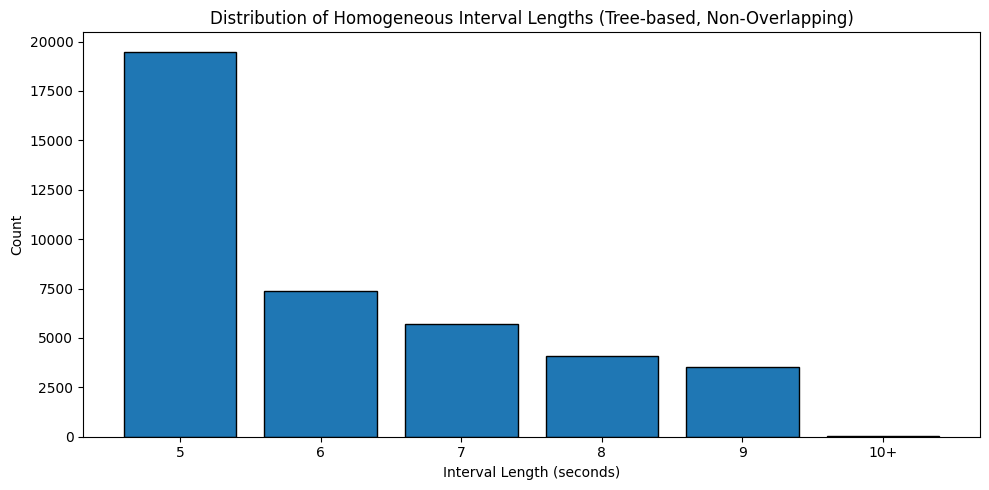

In [ ]:
# --------------------------------------------------------
# Analysis: Sample Interval Length Distribution via Multivariate Tree
# --------------------------------------------------------
# This script applies a multivariate regression tree per sub-trip
# to identify non-overlapping homogeneous segments. It then:
# 1. Extracts interval lengths from split thresholds,
# 2. Computes basic statistics,
# 3. Plots a histogram of segment durations.
# --------------------------------------------------------

# ==== CONFIGURE THESE ====
csv_path = "data_subtrip.csv"
trip_id_col = "sub_trip"
time_variable = "row_in_sub_trip"
X_critical = ["EngineSpeed", "Acceleration", "Slope", "VehicleSpeed"]
y = "FuelRate"
y_var =  "FuelRate"
subjects="sub_trip"
parent_subjects= "Trip"
min_samples_split = 2
min_samples_leaf = 5
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from sklearn.utils import shuffle

# --------------------------------------------------------
# Load Data
# --------------------------------------------------------
df_all = pd.read_csv(csv_path)
whitened_df= whiten_multivariate_targets(
    df_all,
    X_critical,
    y_var,
    subjects,
    parent_subjects,
    eps=1e-6,
    effect="vimp",                # {"vimp", "corr", "corr2", None}
    gamma=1.0,
    weight_norm="sum",           # {"sum", "mean", None}
    min_weight=1e-8,
    n_estimators=200,
    random_state=42,
    return_transform=False,
)

# Assign time index within each sub-trip (starts at 1)
df_all[time_variable] = df_all.groupby(trip_id_col).cumcount() + 1

# --------------------------------------------------------
# Helper: Convert threshold list to segment lengths
# --------------------------------------------------------
def thresholds_to_lengths(thresholds):
    """
    Converts list of split thresholds (e.g., [-1, t1, t2, ..., T-1])
    into segment lengths by computing pairwise differences.
    """
    return np.diff(np.array(thresholds, dtype=int))

# --------------------------------------------------------
# Step 1: Apply detection per sub-trip
# --------------------------------------------------------
all_interval_lengths = []

for _, g in df_all.groupby(trip_id_col, sort=False):
    thresholds_lists = multivariable_tree_non_overlapping_homogeneous_interval_detection(
        g,
        y_var=y,
        time_variable=time_variable,
        X_critical=X_critical,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    # Function returns one list inside a list
    th = thresholds_lists[0]
    all_interval_lengths.extend(thresholds_to_lengths(th).tolist())

all_interval_lengths = np.asarray(all_interval_lengths, dtype=float)

# --------------------------------------------------------
# Step 2: Print Summary Stats + Plot Histogram
# --------------------------------------------------------
if all_interval_lengths.size:
    # Summary statistics
    mean_len = float(all_interval_lengths.mean())
    q_min, q1, q2, q3, q_max = np.percentile(all_interval_lengths, [0, 25, 50, 75, 100])

    print(f"Intervals counted (all sub-trips): {len(all_interval_lengths)}")
    print(f"Average (mean): {mean_len:.3f} seconds")
    print(f"Min: {q_min:.3f} seconds")
    print(f"25th percentile (Q1): {q1:.3f} seconds")
    print(f"Median (Q2): {q2:.3f} seconds")
    print(f"75th percentile (Q3): {q3:.3f} seconds")
    print(f"Max: {q_max:.3f} seconds")

    # Flexible binning: 5–max in 1s bins, 10+ aggregated into one final bin
    lengths_int = all_interval_lengths.astype(int)
    max_display = 9  # e.g., 5–9 displayed individually
    start_display = 5

    # Count bins: 5–9
    per_point_counts = [int(np.sum(lengths_int == k)) for k in range(start_display, max_display + 1)]
    count_10plus = int(np.sum(lengths_int > max_display))  # Aggregate 10+

    x_positions = list(range(start_display, max_display + 1)) + [max_display + 1]
    x_labels = [str(k) for k in range(start_display, max_display + 1)] + [f"{max_display + 1}+"]
    y_counts = per_point_counts + [count_10plus]

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(x_positions, y_counts, edgecolor='black')
    plt.xticks(ticks=x_positions, labels=x_labels)
    plt.xlabel("Interval Length (seconds)")
    plt.ylabel("Count")
    plt.title("Distribution of Homogeneous Interval Lengths (Tree-based, Non-Overlapping)")
    plt.tight_layout()
    plt.show()

else:
    print("No intervals were produced. Check column names and detection settings.")

In [4]:
# --------------------------------------------------------
# Function: univariable_tree_non_overlapping_homogeneous_interval_detection
# --------------------------------------------------------
# This function detects homogeneous intervals using univariate decision
# trees, one for each variable in `X_critical`. For each target variable,
# a decision tree is trained using `time_variable` as the sole input.
#
# The split thresholds from all trees are extracted, merged, and sorted
# to determine change points across time. These split points define
# non-overlapping homogeneous intervals over the sequence.
#
# Parameters:
# - df: Input DataFrame containing time and target variables.
# - time_variable: Name of the column representing time or sequence order.
# - X_critical: List of target variable names for univariate tree regression.
# - min_samples_split: Minimum number of samples required to split an internal node.
# - min_samples_leaf: Minimum number of samples required to be at a leaf node.
#
# Returns:
# - List[List[int]]: A single-element list containing sorted split indices
#   that mark the ends of homogeneous intervals.

from sklearn.tree import DecisionTreeRegressor
import numpy as np

def univariable_tree_non_overlapping_homogeneous_interval_detection(
    df,
    time_variable,
    X_critical,
    min_samples_split=2,
    min_samples_leaf=1
):

    new_df2 = df.copy()

    # Fit univariate tree on each target in X_critical
    regr_tree = DecisionTreeRegressor(min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
    X = new_df2.loc[:, time_variable:time_variable]  # Select column as DataFrame

    thresholdtemp = [-1]  # Start with a virtual boundary before index 0

    for target in X_critical:
        y = new_df2[target]
        regr_tree.fit(X, y)

        # Extract thresholds only from the root feature (time_variable = 0)
        threshold = regr_tree.tree_.threshold
        feature = regr_tree.tree_.feature
        feature_threshold = np.floor(threshold[feature == 0]).astype(int)

        thresholdtemp.extend(feature_threshold)

    # Remove duplicates and add final boundary at end of sequence
    thresholds = []
    for val in thresholdtemp:
        if val not in thresholds:
            thresholds.append(val)

    thresholds.append(len(df) - 1)  # Final point
    thresholds = sorted(thresholds)

    return [thresholds]  # Returned as list of one list (for consistency)


Intervals counted (all sub-trips): 104846
Average (mean): 2.354 seconds
Min: 1.000 seconds
25th percentile (Q1): 1.000 seconds
Median (Q2): 2.000 seconds
75th percentile (Q3): 3.000 seconds
Max: 26.000 seconds


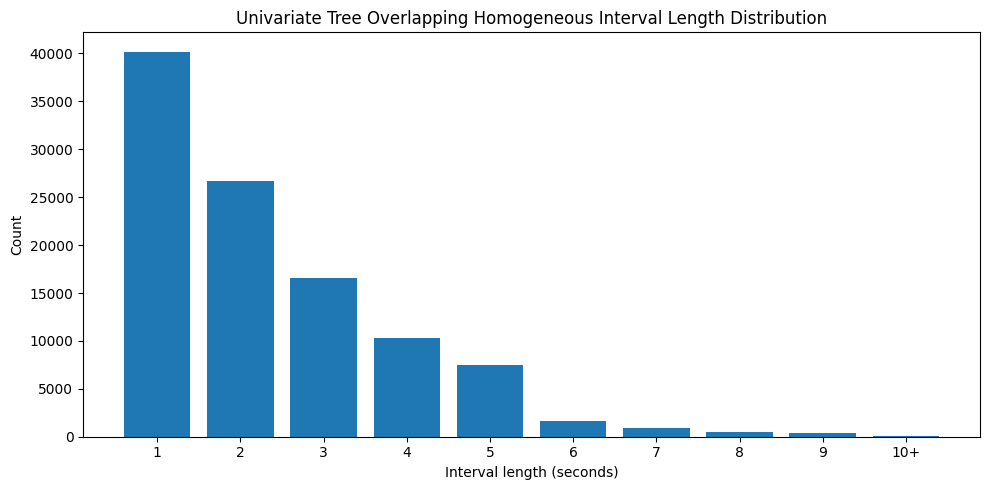

In [ ]:
# --------------------------------------------------------
# Script: Sample Plotting Overlapping Homogeneous Intervals (Univariate Tree)
# --------------------------------------------------------
# This script uses univariate decision trees to detect homogeneous regions
# within each sub-trip. It computes the interval lengths based on tree splits
# and visualizes their distribution.
# --------------------------------------------------------

# ==== CONFIGURE THESE ====
csv_path = "data_subtrip.csv"
trip_id_col = "sub_trip"
time_variable = "row_in_sub_trip"
X_critical = ["EngineSpeed", "Acceleration", "Slope", "VehicleSpeed"]
min_samples_split = 2
min_samples_leaf = 5
y = "FuelRate"
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# --------------------------------------------------------
# Helper Function: thresholds_to_lengths
# --------------------------------------------------------
def thresholds_to_lengths(thresholds):
    """
    Converts a list of threshold boundaries to interval lengths.

    Parameters:
        thresholds (list[int]): List of split boundaries (sorted).

    Returns:
        np.ndarray: Differences between successive split points.
    """
    return np.diff(np.array(thresholds, dtype=int))

# --------------------------------------------------------
# Main Processing
# --------------------------------------------------------

# Load dataset
df_all = pd.read_csv(csv_path)

# Ensure time_variable counts from 1 within each sub-trip
df_all[time_variable] = df_all.groupby(trip_id_col).cumcount() + 1

all_interval_lengths = []

# Apply split detection for each sub-trip
for _, g in df_all.groupby(trip_id_col, sort=False):
    thresholds_lists = univariable_tree_non_overlapping_homogeneous_interval_detection(
        g,
        time_variable=time_variable,
        X_critical=X_critical,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Compute interval lengths from each set of thresholds
    for th in thresholds_lists:
        all_interval_lengths.extend(thresholds_to_lengths(th).tolist())

# Convert to NumPy array for further analysis
all_interval_lengths = np.asarray(all_interval_lengths, dtype=float)

# --------------------------------------------------------
# Summary and Visualization
# --------------------------------------------------------

if all_interval_lengths.size:
    # Compute summary stats
    mean_len = float(all_interval_lengths.mean())
    q_min, q1, q2, q3, q_max = np.percentile(all_interval_lengths, [0, 25, 50, 75, 100])

    print(f"Intervals counted (all sub-trips): {len(all_interval_lengths)}")
    print(f"Average (mean): {mean_len:.3f} seconds")
    print(f"Min: {q_min:.3f} seconds")
    print(f"25th percentile (Q1): {q1:.3f} seconds")
    print(f"Median (Q2): {q2:.3f} seconds")
    print(f"75th percentile (Q3): {q3:.3f} seconds")
    print(f"Max: {q_max:.3f} seconds")

    # Build bar chart for lengths 1–9, with 10+ aggregated
    lengths_int = all_interval_lengths.astype(int)
    per_point_counts = [int(np.sum(lengths_int == k)) for k in range(1, 10)]
    count_10plus = int(np.sum(lengths_int >= 10))

    x_positions = list(range(1, 10)) + [10]
    x_labels = [str(k) for k in range(1, 10)] + ["10+"]
    y_counts = per_point_counts + [count_10plus]

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(x_positions, y_counts)
    plt.xticks(x_positions, x_labels)
    plt.xlabel("Interval length (seconds)")
    plt.ylabel("Count")
    plt.title("Univariate Tree Overlapping Homogeneous Interval Length Distribution")
    plt.tight_layout()
    plt.show()

else:
    print("No intervals were produced. Check column names and detection settings.")


In [5]:
# --------------------------------------------------------
# Function: univariable_tree_overlapping_homogeneous_interval_detection
# --------------------------------------------------------
# This function detects overlapping homogeneous intervals by applying a
# univariate decision tree to each variable in `X_critical`, using only
# `time_variable` as the predictor. For each target variable, a separate
# regression tree is trained to identify split thresholds that indicate
# changes in statistical behavior over time.
#
# The resulting thresholds from each tree define homogeneous intervals
# for that specific variable. Since each variable is processed independently,
# the intervals may overlap across variables.
#
# For each variable, the function returns a list of sorted threshold indices,
# including artificial start and end boundaries: [-1, ..., len(df) - 1].
#
# Parameters:
# - df: Input DataFrame containing time and target variables.
# - time_variable: Name of the column used as the regression input (time index).
# - X_critical: List of variable names to be used as regression targets.
# - min_samples_split: Minimum number of samples required to split an internal node.
# - min_samples_leaf: Minimum number of samples required to be at a leaf node.
#
# Returns:
# - List[List[int]]: A list where each element corresponds to one target variable
#   and contains its sorted list of interval boundary indices.

from sklearn.tree import DecisionTreeRegressor
import numpy as np

def univariable_tree_overlapping_homogeneous_interval_detection(
    df,
    time_variable,
    X_critical,
    min_samples_split=2,
    min_samples_leaf=1
):

    new_df2 = df.copy()

    # Decision Tree (univariate) setup
    regr_tree = DecisionTreeRegressor(
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # X is the single predictor: time variable
    X = new_df2.loc[:, time_variable:time_variable]

    all_thresholds_per_column = []  # stores thresholds for each target variable

    # Fit one tree per variable in X_critical
    for target in X_critical:
        y = new_df2[target]

        # Fit regression tree for this variable
        regr_tree.fit(X, y)

        threshold = regr_tree.tree_.threshold
        feature = regr_tree.tree_.feature

        # Extract thresholds for splits on time_variable (feature index 0)
        feature_threshold = np.floor(threshold[feature == 0]).astype(int)

        # Deduplicate + sort thresholds
        unique_sorted_thresholds = sorted(set(feature_threshold.tolist()))

        # Add start/end boundaries
        thresholds_with_bounds = [-1] + unique_sorted_thresholds + [len(df) - 1]

        # Store thresholds for this target
        all_thresholds_per_column.append(thresholds_with_bounds)

    return all_thresholds_per_column


Intervals counted (all sub-trips): 62816
Average (mean): 15.719 seconds
Min: 1.000 seconds
25th percentile (Q1): 7.000 seconds
Median (Q2): 14.000 seconds
75th percentile (Q3): 23.000 seconds
Max: 732.000 seconds


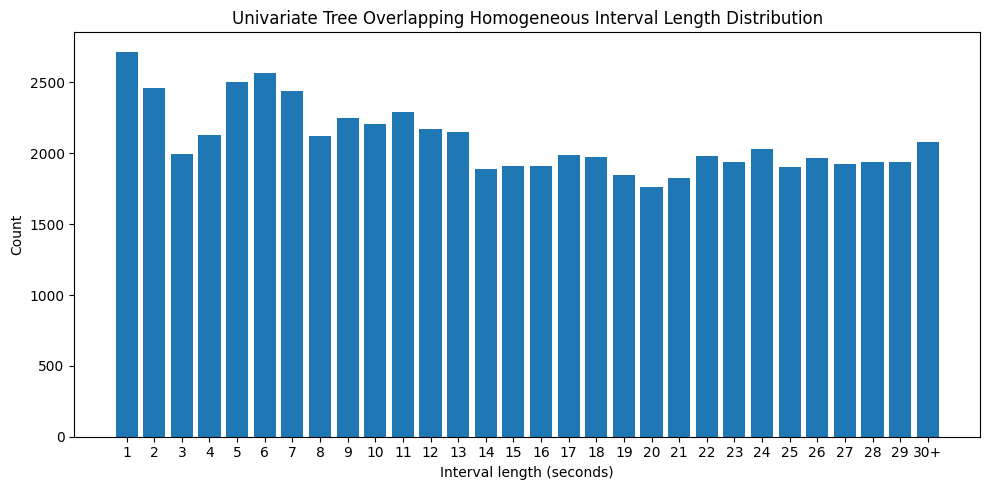

In [ ]:
# --------------------------------------------------------
# PLOT: Overlapping Homogeneous Interval Lengths using Univariate Tree
# --------------------------------------------------------
# This script:
# - Loads per-second vehicle data split by sub-trips
# - Detects homogeneous intervals for each variable using univariate trees
# - Allows overlapping intervals (i.e., separate trees per variable)
# - Plots the distribution of detected interval lengths
# --------------------------------------------------------

# ==== CONFIGURE THESE ====
csv_path = "data_subtrip.csv"  # Input data path
trip_id_col = "sub_trip"       # Trip/grouping column
time_variable = "row_in_sub_trip"  # Time index column
X_critical = ["EngineSpeed", "Acceleration", "Slope", "VehicleSpeed"]  # Target variables
min_samples_split = 30
min_samples_leaf = 1
y = "FuelRate"
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# --------------------------------------------------------
# Helper: Convert list of thresholds to interval lengths
# --------------------------------------------------------
def thresholds_to_lengths(thresholds):
    """
    Given thresholds like [-1, t1, t2, ..., T-1], return lengths between them.
    """
    return np.diff(np.array(thresholds, dtype=int))


# --------------------------------------------------------
# Main Analysis
# --------------------------------------------------------

# Load data
df_all = pd.read_csv(csv_path)

# Create time index per sub-trip (each row = 1 second)
df_all[time_variable] = df_all.groupby(trip_id_col).cumcount() + 1

all_interval_lengths = []

# Apply detection per sub-trip
for _, g in df_all.groupby(trip_id_col, sort=False):
    thresholds_lists = univariable_tree_overlapping_homogeneous_interval_detection(
        g,
        time_variable=time_variable,
        X_critical=X_critical,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Loop over each variable’s thresholds
    for th in thresholds_lists:
        all_interval_lengths.extend(thresholds_to_lengths(th).tolist())

all_interval_lengths = np.asarray(all_interval_lengths, dtype=float)

# --------------------------------------------------------
# Summary statistics + hybrid bar chart
# --------------------------------------------------------
if all_interval_lengths.size:
    # Descriptive stats
    mean_len = float(all_interval_lengths.mean())
    q_min, q1, q2, q3, q_max = np.percentile(all_interval_lengths, [0, 25, 50, 75, 100])

    print(f"Intervals counted (all sub-trips): {len(all_interval_lengths)}")
    print(f"Average (mean): {mean_len:.3f} seconds")
    print(f"Min: {q_min:.3f} seconds")
    print(f"25th percentile (Q1): {q1:.3f} seconds")
    print(f"Median (Q2): {q2:.3f} seconds")
    print(f"75th percentile (Q3): {q3:.3f} seconds")
    print(f"Max: {q_max:.3f} seconds")

    # ---- Bar chart bins: 1–29 individual, 30+ aggregated ----
    lengths_int = all_interval_lengths.astype(int)
    per_point_counts = [int(np.sum(lengths_int == k)) for k in range(1, 30)]
    count_30plus = int(np.sum(lengths_int >= 30))

    x_positions = list(range(1, 30)) + [30]
    x_labels = [str(k) for k in range(1, 30)] + ["30+"]
    y_counts = per_point_counts + [count_30plus]

    # Plot bar chart
    plt.figure()
    plt.bar(x_positions, y_counts)
    plt.xticks(x_positions, x_labels)
    plt.xlabel("Interval length (seconds)")
    plt.ylabel("Count")
    plt.title("Univariate Tree Overlapping Homogeneous Interval Length Distribution")
    plt.tight_layout()
    plt.show()

else:
    print("No intervals were produced. Check column names and detection settings.")


In [6]:
# --------------------------------------------------------
# Function: summation_critical_interval
# --------------------------------------------------------
# This function performs aggregation of time series data over
# homogeneous intervals detected by tree-based segmentation methods.
# Based on the selected `aggregation_type`, it detects either
# overlapping or non-overlapping critical intervals using
# univariate or multivariate regression trees.
#
# Within each detected interval, it applies a set of statistical
# summary functions to selected variables (`X_functional`, `X_scalar`,
# `X_specific_summary_list`, and target `y`) and records the results
# at the start index of each segment. The function supports a wide
# range of summary types such as mean, sum, std, median, and others.
#
# Aggregation metadata such as segment size and aggregation method
# are also stored in the output. Finally, the result is filtered to
# return only rows where aggregation was applied.
#
# Parameters:
# - df: Input DataFrame containing time series data.
# - aggregation_type: Method for detecting critical intervals; one of:
#     'critical_interval_noa_per_covariate',
#     'critical_interval_noa_multi_covariate',
#     'critical_interval_oa_per_covariate'.
# - time_variable: Column name representing the time or sequence index.
# - min_samples_split: Minimum number of samples required to split a tree node.
# - min_samples_leaf: Minimum number of samples required in a leaf node.
# - X_functional: List of functional (time-varying) variables to summarize.
# - X_critical: List of variables used to define the segmentation.
# - X_common_summary_list: List of summary statistics to apply to all functional variables.
# - X_scalar: List of scalar variables to summarize (mean only).
# - X_specific_summary_list: List of (variable, summary) pairs for custom aggregation.
# - y: Name of the target variable to summarize.
# - y_type: Type of the target variable ('functional' or 'scalar').
# - y_summary: Summary statistic to apply to `y` (if functional).
#
# Returns:
# - pd.DataFrame: A new DataFrame containing aggregated statistics for each
#   homogeneous interval, with one row per interval and additional metadata columns.


def summation_critical_interval(
    df,
    aggregation_type,
    time_variable,
    min_samples_split,
    min_samples_leaf,
    X_functional,
    X_critical,
    X_common_summary_list,
    X_scalar,
    X_specific_summary_list,
    y,
    y_type,
    y_summary
):
    new_df = df

    # --------------------------------------------------------
    # Select method for detecting interval thresholds
    # --------------------------------------------------------
    if aggregation_type == "critical_interval_noa_per_covariate":
        thresholds2 = univariable_tree_non_overlapping_homogeneous_interval_detection(
            df, time_variable, X_critical, min_samples_split,min_samples_leaf
        )
    elif aggregation_type == "critical_interval_noa_multi_covariate":
        thresholds2 = multivariable_tree_non_overlapping_homogeneous_interval_detection(
            df, time_variable, X_critical, min_samples_split,min_samples_leaf
        )
    elif aggregation_type == "critical_interval_oa_per_covariate":
        thresholds2 = univariable_tree_overlapping_homogeneous_interval_detection(
            df, time_variable, X_critical, min_samples_split,min_samples_leaf
        )
    else:
        print("WARNING: the aggregation method is not supported")

    # --------------------------------------------------------
    # Basic validation
    # --------------------------------------------------------
    if min_samples_split > len(df):
        print("WARNING: min_samples_split is bigger than the data size")
    elif min_samples_split == 1:
        min_samples_split = 2
        print("WARNING: min_samples_split must be >= 2. Changed to 2.")
    elif min_samples_leaf > len(df):
        print("WARNING: min_samples_leaf is bigger than the data size")
    elif min_samples_leaf <1:
        min_samples_leaf = 1
        print("WARNING: min_samples_leaf must be >= 1. Changed to 1.")

    else:
        r = range(len(thresholds2) - 1)
        if len(r) == 0:
            r = [0]  # fallback to ensure loop runs at least once

        # --------------------------------------------------------
        # Iterate over all detected intervals
        # --------------------------------------------------------
        for j in r:
            thresholds = thresholds2[j]
            for i in range(len(thresholds) - 1):
                start = thresholds[i] + 1
                end = thresholds[i + 1]
                temps = new_df.loc[start:end]

                # --- Apply summaries to functional variables ---
                for variable in X_functional:
                    temp = temps[variable].tolist()
                    for summary in X_common_summary_list:
                        text = summary + "_" + variable
                        if summary == 'mean':
                            new_df.at[start, text] = np.sum(temp) / (end - start + 1)
                        elif summary == 'sum':
                            new_df.at[start, text] = np.sum(temp)
                        elif summary == 'std':
                            new_df.at[start, text] = np.std(temp)
                        elif summary == 'var':
                            new_df.at[start, text] = np.var(temp)
                        elif summary == 'min':
                            new_df.at[start, text] = np.min(temp)
                        elif summary == 'max':
                            new_df.at[start, text] = np.max(temp)
                        elif summary == 'median':
                            new_df.at[start, text] = np.median(temp)
                        elif summary == 'range':
                            new_df.at[start, text] = np.nanmax(temp) - np.nanmin(temp)
                        elif summary == 'mode':
                            new_df.at[start, text] = stats.mode(temp)
                        elif summary == 'meanabs':
                            new_df.at[start, text] = np.sum(np.abs(temp)) / (end - start + 1)
                        elif summary == 'zero_portion':
                            new_df.at[start, text] = len([ele for ele in temp if ele == 0]) / (len(temp) + 1)
                        elif summary == 'positive_portion':
                            new_df.at[start, text] = len([ele for ele in temp if ele > 0]) / (len(temp) + 1)
                        else:
                            print("summary", summary, "is not supported")

                # --- Apply summary to scalar variables (mean only) ---
                for variable in X_scalar:
                    temp = temps[variable].tolist()
                    summary = "mean"
                    text = summary + "_" + variable
                    new_df.at[start, text] = np.sum(temp) / (end - start + 1)

                # --- Apply specific summaries ---
                if len(X_specific_summary_list) > 0:
                    for j in range(len(X_specific_summary_list)):
                        variable = X_specific_summary_list[j][0]
                        summary = X_specific_summary_list[j][1]
                        temp = temps[variable].tolist()
                        text = summary + "_" + variable
                        if summary == 'mean':
                            new_df.at[start, text] = np.sum(temp) / (end - start + 1)
                        elif summary == 'sum':
                            new_df.at[start, text] = np.sum(temp)
                        elif summary == 'std':
                            new_df.at[start, text] = np.std(temp)
                        elif summary == 'var':
                            new_df.at[start, text] = np.var(temp)
                        elif summary == 'min':
                            new_df.at[start, text] = np.min(temp)
                        elif summary == 'max':
                            new_df.at[start, text] = np.max(temp)
                        elif summary == 'median':
                            new_df.at[start, text] = np.median(temp)
                        elif summary == 'range':
                            new_df.at[start, text] = np.nanmax(temp) - np.nanmin(temp)
                        elif summary == 'mode':
                            new_df.at[start, text] = stats.mode(temp)
                        elif summary == 'meanabs':
                            new_df.at[start, text] = np.sum(np.abs(temp)) / (end - start + 1)
                        elif summary == 'zero_portion':
                            new_df.at[start, text] = len([ele for ele in temp if ele == 0]) / (len(temp) + 1)
                        elif summary == 'positive_portion':
                            new_df.at[start, text] = len([ele for ele in temp if ele > 0]) / (len(temp) + 1)
                        else:
                            print("summary", summary, "is not supported")

                # --- Process y variable ---
                variable = y
                temp = temps[variable].tolist()

                if y_type == "functional":
                    summary = y_summary
                    text = summary + "_" + variable
                    if summary == 'mean':
                        new_df.at[start, text] = np.sum(temp) / (end - start + 1)
                    elif summary == 'sum':
                        new_df.at[start, text] = np.sum(temp)
                    elif summary == 'std':
                        new_df.at[start, text] = np.std(temp)
                    elif summary == 'var':
                        new_df.at[start, text] = np.var(temp)
                    elif summary == 'min':
                        new_df.at[start, text] = np.min(temp)
                    elif summary == 'max':
                        new_df.at[start, text] = np.max(temp)
                    elif summary == 'median':
                        new_df.at[start, text] = np.median(temp)
                    elif summary == 'range':
                        new_df.at[start, text] = np.nanmax(temp) - np.nanmin(temp)
                    elif summary == 'mode':
                        new_df.at[start, text] = stats.mode(temp)
                    elif summary == 'meanabs':
                        new_df.at[start, text] = np.sum(np.abs(temp)) / (end - start + 1)
                    elif summary == 'zero_portion':
                        new_df.at[start, text] = len([ele for ele in temp if ele == 0]) / (len(temp) + 1)
                    elif summary == 'positive_portion':
                        new_df.at[start, text] = len([ele for ele in temp if ele > 0]) / (len(temp) + 1)
                    else:
                        print("summary", summary, "is not supported")
                else:
                    # y treated as scalar
                    text = "mean_" + variable
                    new_df.at[start, text] = np.sum(temp) / (end - start + 1)
                    text = "var_" + variable
                    new_df.at[start, text] = np.var(temp)

                # --- Assign aggregation metadata ---
                new_df.at[start, "agg_size"] = (end - start + 1)
                new_df.at[start, "agg_level"] = (end - start + 1)
                new_df.at[start, "agg_type"] = "complete"

                if aggregation_type == "critical_interval_noa_per_covariate":
                    new_df.at[start, "agg_method"] = "critical_interval_noa_per_covariate"
                elif aggregation_type == "critical_interval_noa_multi_covariate":
                    new_df.at[start, "agg_method"] = "critical_interval_noa_multi_covariate"
                elif aggregation_type == "critical_interval_oa_per_covariate":
                    new_df.at[start, "agg_method"] = "critical_interval_oa_per_covariate"
                else:
                    print("WARNING: the aggregation method is not supported")

        # --------------------------------------------------------
        # Keep only rows with filled aggregated summaries
        # --------------------------------------------------------
        new_df = new_df[(new_df["agg_type"] == "complete")]
        new_df = new_df.reset_index(drop=True)

    return new_df



# **Data preparation**

In this section, we prepare the data by applying the appropriate summarization functions.

In [4]:
# --------------------------------------------------------
# Function: data_prep_raw
# --------------------------------------------------------
# This function performs subject-wise data preparation by applying
# the selected aggregation method to each subject (e.g., each trip)
# in the dataset. It supports multiple strategies for generating
# interval-based summaries:
#
# - "non_overlapping": Applies fixed-size intervals with no overlap.
# - "overlapping": Applies sliding window aggregation with a fixed step size.
# - "critical_interval_*": Applies tree-based segmentation (univariate or multivariate)
#     to define homogeneous intervals and summarize variables accordingly.
#
# For each subject, the relevant interval summarization function is called
# (`summation_overlapping`, `summation_non_overlapping`, or
# `summation_critical_interval`), and the results are combined into a
# single DataFrame with one row per interval.
#
# Parameters:
# - data: Full input DataFrame containing all subjects.
# - time_variable: Column representing time or sequence index within a subject.
# - min_samples_split: Minimum number of samples to split a node (for tree-based methods).
# - min_samples_leaf: Minimum number of samples in a leaf node (for tree-based methods).
# - subjects: Column name identifying individual subjects (e.g., trip ID).
# - y: Name of the target variable.
# - y_type: Type of target variable ("functional" or "scalar").
# - y_summary: Summary function to apply to `y` (e.g., "mean").
# - aggregation_type: Aggregation strategy to use; one of:
#     "overlapping", "non_overlapping",
#     "critical_interval_oa_per_covariate",
#     "critical_interval_noa_per_covariate",
#     "critical_interval_noa_multi_covariate".
# - step_size: Step size between overlapping windows (used only for overlapping mode).
# - aggregation_var: Variable used to measure aggregation length (e.g., time).
# - interval_size: Size of each interval (in units of `aggregation_var`).
# - X_functional: List of time-varying (functional) predictor variables.
# - X_critical: List of critical variables used for interval detection.
# - X_common_summary_list: List of summary statistics to compute for all functional variables.
# - X_scalar: List of scalar (non-functional) variables to summarize.
# - X_specific_summary_list: Custom list of (variable, summary) pairs for aggregation.
#
# Returns:
# - pd.DataFrame: A cleaned and aggregated DataFrame with interval-level summaries
#   for each subject, ready for modeling or analysis.


def data_prep_raw(data,
                  time_variable,
                  min_samples_split,
                  min_samples_leaf,
                  subjects,
                  y,
                  y_type,
                  y_summary,
                  aggregation_type,
                  step_size,
                  aggregation_var,
                  interval_size,
                  X_functional,
                  X_critical,
                  X_common_summary_list,
                  X_scalar,
                  X_specific_summary_list):

  new_data=data.iloc[:0,:].copy()
  subject_list = data[subjects].unique()
  for subject in subject_list:
    subject_df=data.loc[data[subjects] == subject]
    subject_df=subject_df.reset_index(drop=True)
    if aggregation_type == "overlapping":
      temp=summation_overlapping(subject_df,interval_size,X_functional,X_common_summary_list,X_scalar,X_specific_summary_list,y,y_type,y_summary, aggregation_var,step_size)
    elif aggregation_type == "non_overlapping":
      temp=summation_non_overlapping(subject_df,interval_size,X_functional,X_common_summary_list,X_scalar,X_specific_summary_list,y,y_type,y_summary, aggregation_var)
    elif aggregation_type == "critical_interval_oa_per_covariate":
      temp=summation_critical_interval(subject_df,aggregation_type, time_variable,min_samples_split, min_samples_leaf,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list,y,y_type,y_summary)
    elif aggregation_type == "critical_interval_noa_per_covariate":
      temp=summation_critical_interval(subject_df,aggregation_type, time_variable,min_samples_split, min_samples_leaf,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list,y,y_type,y_summary)
    elif aggregation_type == "critical_interval_noa_multi_covariate":
      # Call whiten_multivariate_targets before summation_critical_interval
      #subject_df = whiten_multivariate_targets(subject_df, X_critical, y)

      temp=summation_critical_interval(subject_df,aggregation_type, time_variable,min_samples_split, min_samples_leaf,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list,y,y_type,y_summary)
    else:
      print("aggregation type is not supported. choose overlapping or non_overlapping or critical_interval")
    new_data = pd.concat([new_data,temp])
  new_data=new_data.dropna()
  new_data=new_data.reset_index(drop=True)

  return new_data


# --------------------------------------------------------
# Function: data_prep
# --------------------------------------------------------

# This is a high-level dispatcher function that prepares interval-based
# aggregated data using one or more aggregation strategies. It wraps
# around `data_prep_raw`, applying one of the following modes:
#
# - "non_overlapping": Fixed-size non-overlapping intervals
# - "overlapping": Overlapping intervals with step size
# - "critical_interval_*": Tree-based segmentation (overlapping or non-overlapping)
#
# Depending on the selected method, it delegates the processing to
# `data_prep_raw`, which performs subject-wise aggregation.
#
# This function is useful for switching between interval strategies
# for experiments or model comparisons.

"""
    High-level data preparation handler.

    Handles composite or dual-pass strategies for aggregation
    like combining overlapping and non-overlapping summaries.

    Parameters:
    - See data_prep_raw

    Returns:
    - new_data: DataFrame with aggregated summaries.
"""

def data_prep(data,
              time_variable,
              min_samples_split,
              min_samples_leaf,
              subjects,
              y,
              y_type,
              y_summary,
              aggregation_type,
              step_size,
              aggregation_var,
              interval_size,
              X_functional,
              X_critical,
              X_common_summary_list,
              X_scalar,
              X_specific_summary_list):

  if aggregation_type == "critical_interval_oa_per_covariate":
    aggregation = "critical_interval_noa_per_covariate"
    new_data=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
    add=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
    new_data=pd.concat([new_data,add])
  elif aggregation_type == "critical_interval_noa_per_covariate":
    new_data=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
  elif aggregation_type == "critical_interval_noa_multi_covariate":
    new_data=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
  else:
    aggregation = "non_overlapping"
    new_data=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
    if aggregation_type == "overlapping":
      add=data_prep_raw(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
      new_data=pd.concat([new_data,add])
  new_data=new_data.dropna()
  new_data=new_data.reset_index(drop=True)
  return new_data


# **Train, test seperation**

In this section, we split the data into training, validation, and test sets using different strategies. Specifically, we apply a subject-wise approach, where one trip is held out for testing, and the remaining trips are used for training and validation via 5-fold cross-validation.

In [6]:
# --------------------------------------------------------
# Function: test_train_split
# --------------------------------------------------------
# This function splits aggregated time series data into training and
# testing sets based on the selected aggregation strategy and split method.
#
# It supports two test separation methods:
# - "subject_wise": Ensures no data leakage by separating entire subjects
#   (e.g., trips) into distinct train/test groups. Useful for cross-validation
#   or evaluation on unseen subjects.
# - "event_wise": Randomly splits rows (events) into train/test sets without
#   enforcing subject separation. Suitable for simpler experiments.
#
# The function supports all major aggregation types:
# - "non_overlapping"
# - "overlapping"
# - "critical_interval_noa_per_covariate"
# - "critical_interval_noa_multi_covariate"
# - "critical_interval_oa_per_covariate"
#
# It prepares feature sets (`X`) and response values (`y`) for:
# - Training
# - Block-based testing (one test block per test subject group)
# - Test-time analysis on individual sub-subjects (e.g., sub-trips)
#
# Parameters:
# - data: Aggregated DataFrame containing predictor/response columns and metadata.
# - subjects: Column name identifying fine-grained subjects (e.g., sub_trips).
# - parent_subjects: Column name identifying higher-level subjects (e.g., trips).
# - y: Target variable name.
# - y_type: Type of the target variable ("functional" or "scalar").
# - y_summary: Summary method applied to target variable during aggregation.
# - X_scalar: List of scalar (non-functional) predictor variables.
# - X_functional: List of functional predictor variables (aggregated over intervals).
# - X_common_summary_list: List of summaries applied to all functional variables.
# - X_specific_summary_list: List of (variable, summary) pairs for custom aggregation.
# - aggregation_type: Aggregation method used to produce the data. Must match one of:
#     "non_overlapping", "overlapping",
#     "critical_interval_noa_per_covariate",
#     "critical_interval_noa_multi_covariate",
#     "critical_interval_oa_per_covariate".
# - test_seperation_method: One of "subject_wise" or "event_wise".
# - test_portion: Portion of data used for test set (used only for event-wise split).
# - test_num: Number of subject groups used for testing (used only for subject-wise split).
# - group_num: Number of cross-validation groups (subject-wise only).
#
# Returns:
# - X_train: List of training feature DataFrames for each fold or group.
# - y_train: List of training target values for each group.
# - X_test_blocks: List of test block feature DataFrames.
# - y_test_blocks: List of test block target values.
# - X_test_TT: List of test-time individual subject feature sets.
# - y_test_TT: List of corresponding test-time target values.
# - Duration_test_TT: List of interval durations for each test-time subject.
# - Subject_test_TT: List of subject IDs for each test-time interval group.


def test_train_split(data,
                     subjects,
                     parent_subjects,
                     y,
                     y_type,
                     y_summary,
                     X_scalar,
                     X_functional,
                     X_common_summary_list,
                     X_specific_summary_list,
                     aggregation_type,
                     test_seperation_method='subject_wise',
                     test_portion=0,
                     test_num=1,
                     group_num=0):

# -----------------------------
# 1. Define response and predictors
# -----------------------------

  if y_type == "functional":
    variable=y
    summary=y_summary
    response=summary+"_"+variable
  else:
    variable=y
    summary="mean"
    response=summary+"_"+variable
  predictors = []
  for variable in X_functional:
    for summary in X_common_summary_list:
      predictors.append(summary+"_"+variable)
  for variable in X_scalar:
    predictors.append("mean_"+variable)
  if len(X_specific_summary_list)>0:
    for k in range(len(X_specific_summary_list)):
      variable = X_specific_summary_list[k][0]
      summary = X_specific_summary_list[k][1]
      predictors.append(summary+"_"+variable)

# -----------------------------
# 2. Subject-wise splitting logic
# -----------------------------

  subject_list = []
  if test_seperation_method =='subject_wise':
    subject_list_raw = data[parent_subjects].unique()
    if len(subject_list_raw)==1:
      print("we need at least 2 subjects. The data has only 1.")
    elif group_num<1:
      if len(subject_list_raw)<test_num:
        print("number of test subjects can not be greater than the total number of subjects in data. we change test number to the number of subjects")
        chunk_size=len(subject_list_raw)
      else:
        chunk_size=test_num
      subject_list = [subject_list_raw[i:i + chunk_size] for i in range(0, len(subject_list_raw), chunk_size)]
      # we must check if this still works by having subject 2 in the code
    elif group_num==1:
      print("group number must be an integer greater or equal to 2. group number changes to 2")
      group_number=2
      subject_list = np.array_split(subject_list_raw, group_number)
    else:
      if len(subject_list_raw)<group_num:
        print("group number must be smaller or equal to the total number of subjects. Group number changed to the total number of subjects.")
        group_number=len(subject_list_raw)
      else:
        group_number=group_num
      subject_list = np.array_split(subject_list_raw, group_number)

# -----------------------------
# 3. Training and Testing
# -----------------------------

  if test_seperation_method =='subject_wise':
    X_train=[]
    y_train=[]
    X_test_blocks=[]
    y_test_blocks=[]
    X_test_TT=[]
    y_test_TT=[]
    Duration_test_TT=[]
    Subject_test_TT=[]
    for subject in subject_list:
      subject_list_raw = data[parent_subjects].unique()
      non_subject=[x for x in subject_list_raw if x not in subject]
        #train
      if aggregation_type=="overlapping":
        data_train=data[(data[parent_subjects].isin(non_subject)) & (data["agg_method"] == "overlapping")]
        #data_train.drop(data_train.tail(1).index,inplace = True)
        data_train.reset_index(drop=True, inplace=True)
        sub_X_train = data_train[predictors]
        sub_y_train= data_train[response]
      #block test - need to change with subject2 logic
        data_test_blocks = data[(data[parent_subjects].isin(subject)) & (data["agg_method"] == "overlapping")]
        data_test_blocks.reset_index(drop=True, inplace=True)
        sub_X_test_blocks= data_test_blocks[predictors]
        sub_y_test_blocks = data_test_blocks[response]
      #test
        data_test_TT=[]
        sub_X_test_TT=[]
        sub_y_test_TT =[]
        sub_Duration_test_TT=[]
        sub_Subject_test_TT=[]
        subject_list_2 = data_test_blocks[subjects].unique()
        for subject2 in subject_list_2:
          data_subject2 = data[(data[subjects]==subject2) & (data["agg_method"] == "non_overlapping")]
          data_subject2=data_subject2.reset_index(drop=True, inplace=False)
          data_subject2_X=data_subject2[predictors]
          data_subject2_y=data_subject2[response]
          data_subject2_Duration=data_subject2['agg_size']
          data_subject2_Subject=data_subject2[subjects]
          data_test_TT.append(data_subject2)
          sub_X_test_TT.append(data_subject2_X)
          sub_y_test_TT.append(data_subject2_y)
          sub_Duration_test_TT.append(data_subject2_Duration)
          sub_Subject_test_TT.append(data_subject2_Subject)
      elif aggregation_type=="non_overlapping":
        data_train=data[(data[parent_subjects].isin(non_subject)) & (data["agg_method"] == "non_overlapping") & (data["agg_type"] == "complete")]
        #data_train.drop(data_train.tail(1).index,inplace = True)
        data_train.reset_index(drop=True, inplace=True)
        sub_X_train = data_train[predictors]
        sub_y_train= data_train[response]
      #block test - need to change with subject2 logic
        data_test_blocks = data[(data[parent_subjects].isin(subject)) & (data["agg_method"] == "non_overlapping") & (data["agg_type"] == "complete")]
        data_test_blocks.reset_index(drop=True, inplace=True)
        sub_X_test_blocks= data_test_blocks[predictors]
        sub_y_test_blocks = data_test_blocks[response]
      #test
        data_test_TT=[]
        sub_X_test_TT=[]
        sub_y_test_TT =[]
        sub_Duration_test_TT=[]
        sub_Subject_test_TT=[]
        subject_list_2 = data_test_blocks[subjects].unique()
        for subject2 in subject_list_2:
          data_subject2 = data[(data[subjects]==subject2) & (data["agg_method"] == "non_overlapping")]
          data_subject2=data_subject2.reset_index(drop=True, inplace=False)
          data_subject2_X=data_subject2[predictors]
          data_subject2_y=data_subject2[response]
          data_subject2_Duration=data_subject2['agg_size']
          data_subject2_Subject=data_subject2[subjects]
          data_test_TT.append(data_subject2)
          sub_X_test_TT.append(data_subject2_X)
          sub_y_test_TT.append(data_subject2_y)
          sub_Duration_test_TT.append(data_subject2_Duration)
          sub_Subject_test_TT.append(data_subject2_Subject)
      elif aggregation_type=="critical_interval_noa_per_covariate":
        data_train=data[(data[parent_subjects].isin(non_subject)) & (data["agg_method"] == "critical_interval_noa_per_covariate")]
        #data_train.drop(data_train.tail(1).index,inplace = True)
        data_train.reset_index(drop=True, inplace=True)
        sub_X_train = data_train[predictors]
        sub_y_train= data_train[response]
      #block test - need to change with subject2 logic
        data_test_blocks = data[(data[parent_subjects].isin(subject)) & (data["agg_method"] == "critical_interval_noa_per_covariate")]
        data_test_blocks.reset_index(drop=True, inplace=True)
        sub_X_test_blocks= data_test_blocks[predictors]
        sub_y_test_blocks = data_test_blocks[response]
      #test
        data_test_TT=[]
        sub_X_test_TT=[]
        sub_y_test_TT =[]
        sub_Duration_test_TT=[]
        sub_Subject_test_TT=[]
        subject_list_2 = data_test_blocks[subjects].unique()
        for subject2 in subject_list_2:
          data_subject2 = data[(data[subjects]==subject2) & (data["agg_method"] == "critical_interval_noa_per_covariate")]
          data_subject2=data_subject2.reset_index(drop=True, inplace=False)
          data_subject2_X=data_subject2[predictors]
          data_subject2_y=data_subject2[response]
          data_subject2_Duration=data_subject2['agg_size']
          data_subject2_Subject=data_subject2[subjects]
          data_test_TT.append(data_subject2)
          sub_X_test_TT.append(data_subject2_X)
          sub_y_test_TT.append(data_subject2_y)
          sub_Duration_test_TT.append(data_subject2_Duration)
          sub_Subject_test_TT.append(data_subject2_Subject)
      elif aggregation_type=="critical_interval_noa_multi_covariate":
        data_train=data[(data[parent_subjects].isin(non_subject)) & (data["agg_method"] == "critical_interval_noa_multi_covariate")]
        #data_train.drop(data_train.tail(1).index,inplace = True)
        data_train.reset_index(drop=True, inplace=True)
        sub_X_train = data_train[predictors]
        sub_y_train= data_train[response]
      #block test - need to change with subject2 logic
        data_test_blocks = data[(data[parent_subjects].isin(subject)) & (data["agg_method"] == "critical_interval_noa_multi_covariate")]
        data_test_blocks.reset_index(drop=True, inplace=True)
        sub_X_test_blocks= data_test_blocks[predictors]
        sub_y_test_blocks = data_test_blocks[response]
      #test
        data_test_TT=[]
        sub_X_test_TT=[]
        sub_y_test_TT =[]
        sub_Duration_test_TT=[]
        sub_Subject_test_TT=[]
        subject_list_2 = data_test_blocks[subjects].unique()
        for subject2 in subject_list_2:
          data_subject2 = data[(data[subjects]==subject2) & (data["agg_method"] == "critical_interval_noa_multi_covariate")]
          data_subject2=data_subject2.reset_index(drop=True, inplace=False)
          data_subject2_X=data_subject2[predictors]
          data_subject2_y=data_subject2[response]
          data_subject2_Duration=data_subject2['agg_size']
          data_subject2_Subject=data_subject2[subjects]
          data_test_TT.append(data_subject2)
          sub_X_test_TT.append(data_subject2_X)
          sub_y_test_TT.append(data_subject2_y)
          sub_Duration_test_TT.append(data_subject2_Duration)
          sub_Subject_test_TT.append(data_subject2_Subject)
      elif aggregation_type=="critical_interval_oa_per_covariate":
        data_train=data[(data[parent_subjects].isin(non_subject)) & (data["agg_method"] == "critical_interval_oa_per_covariate")]
        #data_train.drop(data_train.tail(1).index,inplace = True)
        data_train.reset_index(drop=True, inplace=True)
        sub_X_train = data_train[predictors]
        sub_y_train= data_train[response]
      #block test - need to change with subject2 logic
        data_test_blocks = data[(data[parent_subjects].isin(subject)) & (data["agg_method"] == "critical_interval_oa_per_covariate")]
        data_test_blocks.reset_index(drop=True, inplace=True)
        sub_X_test_blocks= data_test_blocks[predictors]
        sub_y_test_blocks = data_test_blocks[response]
      #test
        data_test_TT=[]
        sub_X_test_TT=[]
        sub_y_test_TT =[]
        sub_Duration_test_TT=[]
        sub_Subject_test_TT=[]
        subject_list_2 = data_test_blocks[subjects].unique()
        for subject2 in subject_list_2:
          data_subject2 = data[(data[subjects]==subject2) & (data["agg_method"] == "critical_interval_noa_per_covariate")]
          data_subject2=data_subject2.reset_index(drop=True, inplace=False)
          data_subject2_X=data_subject2[predictors]
          data_subject2_y=data_subject2[response]
          data_subject2_Duration=data_subject2['agg_size']
          data_subject2_Subject=data_subject2[subjects]
          data_test_TT.append(data_subject2)
          sub_X_test_TT.append(data_subject2_X)
          sub_y_test_TT.append(data_subject2_y)
          sub_Duration_test_TT.append(data_subject2_Duration)
          sub_Subject_test_TT.append(data_subject2_Subject)
      else:
        print("aggregation type is not supported. please choose overlapping or non_overlapping or critical_interval")

      X_train.append(sub_X_train)
      y_train.append(sub_y_train)
      X_test_blocks.append(sub_X_test_blocks)
      y_test_blocks.append(sub_y_test_blocks)
      X_test_TT.append(sub_X_test_TT)
      y_test_TT.append(sub_y_test_TT)
      Duration_test_TT.append(sub_Duration_test_TT)
      Subject_test_TT.append(sub_Subject_test_TT)

# -----------------------------
# 4. Event-wise splitting logic
# -----------------------------

  else:
    if aggregation_type=="overlapping":
      data_complete=data[data["agg_method"] == "overlapping"]
    elif aggregation_type=="non_overlapping":
      data_complete=data[(data["agg_method"] == "non_overlapping") & (data["agg_type"] == "complete")]
    elif aggregation_type=="critical_interval":
      data_complete=data[(data["agg_method"] == "critical_interval")]
    else:
      print("aggregation type is not supported. please choose overlapping or non_overlapping or critical_interval")
    X = data_complete[predictors]
    y = data_complete[response]
    X_train, X_test_blocks, y_train, y_test_blocks = train_test_split(X, y, test_size=test_portion, random_state=42)
    X_train.reset_index(drop=True, inplace=True)
    X_test_blocks.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test_blocks.reset_index(drop=True, inplace=True)
    if aggregation_type=="critical_interval":
      data_test_TT = data[data["agg_method"] == "critical_interval"]
      data_test_TT=data_test_TT.reset_index(drop=True, inplace=False)
      X_test_TT= data_test_TT[predictors]
      y_test_TT = data_test_TT[response]
      Duration_test_TT=data_test_TT['agg_size']
      Subject_test_TT=data_test_TT[subjects]
    else:
      data_test_TT = data[data["agg_method"] == "non_overlapping"]
      data_test_TT=data_test_TT.reset_index(drop=True, inplace=False)
      X_test_TT= data_test_TT[predictors]
      y_test_TT = data_test_TT[response]
      Duration_test_TT=data_test_TT['agg_size']
      Subject_test_TT=data_test_TT[subjects]

# -----------------------------
# 5. Return all datasets
# -----------------------------

  return X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT


# **Hyper Parameter tuning**

In this section, we perform 5-fold cross-validation on the training and validation trips (excluding the test trip). The prediction model (Random Forest) is tuned using this cross-validation process, and the best-performing model is selected to predict the held-out test trip.

In [7]:
# --------------------------------------------------------
# Function: fold_cv
# --------------------------------------------------------
# This function performs k-fold cross-validation (default: 5-fold)
# to find the best hyperparameters for a given prediction model,
# using either Random Forest (RF) or XGBoost (XGB).
#
# For each training group (e.g., subject or fold), a separate model is
# trained using `GridSearchCV` with time-aware cross-validation
# (`TimeSeriesSplit`) and evaluated using RMSE (via negative root mean squared error).
#
# The best model for each group is returned as part of a list.
#
# Supported Models:
# - "RF"  : Random Forest Regressor (from sklearn)
# - "XGB" : XGBoost Regressor (from xgboost)
#
# Parameters:
# - X_train: List of feature DataFrames (one per subject or group).
# - y_train: List of target Series (aligned with `X_train`).
# - prediction_model: Model type, either "RF" or "XGB". Defaults to "RF".
# - n_splits: Number of folds for `TimeSeriesSplit`. Defaults to 5.
#
# Returns:
# - best_model: List of best-fit models (one per training group),
#   each selected based on cross-validated RMSE performance.


"""
    Perform 5-fold cross-validation to find the best hyperparameters
    for a given prediction model (Random Forest or XGBoost).

    Parameters:
    - X_train: List of training feature DataFrames (one per subject/group).
    - y_train: List of training target Series (one per subject/group).
    - prediction_model: String, either "RF" for Random Forest or "XGB" for XGBoost.
    - n_splits: Number of folds in TimeSeriesSplit.

    Returns:
    - best_model: List of fitted best models (one per group).
"""
# sample param grids for RF and XGB

RF_param_grid = {
    "n_estimators" : [100],
    "max_depth" : [5,10],
    "max_features" : [3,5],
    "bootstrap" :[True],
    "oob_score" :[False]}
XGB_param_grid = {
    "n_estimators" : [25, 50, 100, 200],
    "max_depth" : [1, 2, 3, 5, 7, 10],
    "eta" : [0.01, 0.05, 0.1, 0.2],
    "subsample" : [0.632, 1],
    "colsample_bytree" : [0.5, 0.8, 1]}

# initialize a sample list of lists
list_list = [['Acceleration [m.s-2]', 'positive_portion'], ['Slope [%]', 'positive_portion']]
# Create the pandas DataFrame
X_specific_summary_list = pd.DataFrame(list_list, columns=['variables', 'methods'])

# initialize sample values for the parameters of the function
param_grid = {
    "y_type" : "scalar",
    "subject" : "trip",
    "aggretation_var" : "index",
    "X_common_summary_list" : ["average", "median", "variance"],
    "X_specific_summary_list" : X_specific_summary_list,
    "y_summary": ["mean"],
    "interval_selection_methods" : "values_overlapping",
    "aggregation_level" : 30,
    "bootstrapping_method" : "none",
    "prediction_method" : "TA",
    "prediction_model" : "RF",
    "prediction_aggregation_method" : "average",
    "performance_metrics" : ["mean_absolute_error", "mean_squared_error", "mean_absolute_percentage_error","r2_score"]
}

#5-fold CV to find the best hyperparameters for prediction model
def fold_cv(X_train, y_train,prediction_model="RF",n_splits=5):
  if ((prediction_model!="RF") & (prediction_model!="XGB")):
    print("the prediction model is not supported. we support RF and XGB. The model was set to XGB" )
  best_model=[]
  for i in range(len(y_train)):
    sub_X_train=X_train[i]
    sub_y_train=y_train[i]
    cv_fold = TimeSeriesSplit(n_splits=n_splits)
    if prediction_model=="RF":
      param_grid = {
      "n_estimators" : [50,100],
      "max_depth" : [5,10],
      "max_features" : [3,5],
      "bootstrap" :[True],
      "oob_score" :[False]}
      model = RandomForestRegressor(random_state=42)
      search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=cv_fold, scoring="neg_root_mean_squared_error")
      results = search.fit(sub_X_train, sub_y_train)
      best_models = results.best_estimator_
      best_model.append(best_models)
    #best_params = results.best_params_
    #print('Best hyperparameters :', results.best_params_)
    else:
      param_grid = {
      "n_estimators" : [50, 100],
      "max_depth" : [1, 2, 3, 5, 7, 10],
      "eta" : [0.01, 0.05, 0.1, 0.2],
      "subsample" : [0.632, 1],
      "colsample_bytree" : [0.5, 0.8, 1]}
      model = XGBRegressor(random_state=42)
      search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=cv_fold, scoring="neg_root_mean_squared_error")
      results = search.fit(sub_X_train, sub_y_train)
      best_models = results.best_estimator_
      best_model.append(best_models)
      #best_params = results.best_params_
      #print('Best hyperparameters :', results.best_params_)
  return best_model


# **Prediction modeling**

In this section, we define functions to use the training and test data to predict the total fuel consumption of an entire trip. We then define a function to evaluate the prediction performance using MAE and MAPE. In addition, we provide a function to visualize predicted versus actual values and residuals, and finally, a function to export the true and predicted total fuel consumption for each trip to a CSV file in Google Drive.

In [26]:
# --------------------------------------------------------
# Function: predictions_sum
# --------------------------------------------------------
# This function generates total (summed) predictions for each subject
# in the test set, typically representing entire trips or aggregated events.
#
# It applies the trained model (from cross-validation or training) to
# each test-time subject’s prediction blocks (`X_test_TT`), sums the
# predictions across the subject's intervals, and compares the result
# to the true summed target value. This is useful for evaluating
# model performance at the subject (e.g., trip) level rather than
# at the interval level.
#
# Parameters:
# - best_model: List of trained regression models, one per outer subject/group.
# - X_test_TT: List of lists of feature DataFrames for each test-time subject.
# - y_test_TT: List of lists of target Series corresponding to each test-time subject.
# - Duration_test_TT: List of lists of interval durations for each test-time subject.
# - Subject_test_TT: List of lists of subject identifiers.
#
# Returns:
# - output: A DataFrame with one row per test-time subject, containing:
#     - 'subject': Subject ID
#     - 'true'   : True total target value (summed over intervals)
#     - 'pred'   : Predicted total value (summed over model predictions)


def predictions_sum(best_model,
                    X_test_TT,
                    y_test_TT,
                    Duration_test_TT,
                    Subject_test_TT):

  output=pd.DataFrame()
  for i in range(len(y_test_TT)):
    sub_best_model=best_model[i]
    in_sub_X_test_TT=X_test_TT[i]
    in_sub_y_test_TT=y_test_TT[i]
    in_sub_Duration_test_TT=Duration_test_TT[i]
    in_sub_Subject_test_TT=Subject_test_TT[i]
    for j in range(len(y_test_TT[i])):
      sub_X_test_TT=in_sub_X_test_TT[j]
      sub_y_test_TT=in_sub_y_test_TT[j]
      sub_Duration_test_TT=in_sub_Duration_test_TT[j]
      sub_Subject_test_TT=in_sub_Subject_test_TT[j]
      sub_y_test_TT=np.sum(sub_y_test_TT)
      y_TT_pred = np.sum(sub_best_model.predict(sub_X_test_TT))
      sub_y_TT_test_pred = y_TT_pred
    #sub_Subject_test_TTs = list(dict.fromkeys(sub_Subject_test_TT))
    #sub_y_TT_test_pred = np.maximum(y_TT_test_pred, np.zeros(len(sub_y_test_TT)))
      sub_Subject_test_TTs = sub_Subject_test_TT[0]
      sub_output = pd.DataFrame({'subject' : sub_Subject_test_TTs, 'true' : [sub_y_test_TT], 'pred' : [sub_y_TT_test_pred]})
    #'subject' : sub_Subject_test_TT,
    #output.append(sub_output, ignore_index=True)
      output=pd.concat([output,sub_output])
  return output


In [27]:
# --------------------------------------------------------
# Function: performance
# --------------------------------------------------------
# This function computes evaluation metrics to assess the accuracy
# of total trip (or total subject-level) predictions. It compares
# actual vs. predicted summed values per subject using:
#
# - Mean Absolute Error (MAE)
# - Mean Absolute Percentage Error (MAPE)
#
# The results are printed to the console and returned.
#
# Parameters:
# - output: A DataFrame containing two columns:
#     - 'true': Actual summed target values per subject.
#     - 'pred': Predicted summed values per subject.
#
# Returns:
# - MAE (float): Mean Absolute Error, rounded to one decimal place.
# - MAPE (str): Mean Absolute Percentage Error as a percentage string, e.g., "12.3%".


# get the performance metrics for total trip
def performance(output):
    y_test_blocks = output["true"]
    y_test_blocks_pred = output["pred"]

    MAE = mean_absolute_error(y_test_blocks, y_test_blocks_pred)
    MAE = round(MAE, 1)

    MAPE = mean_absolute_percentage_error(y_test_blocks, y_test_blocks_pred)
    MAPE = round(MAPE * 100, 1)  # Convert to percentage
    MAPE = f"{MAPE:.1f}%"


    print(

        "Mean absolute error: ", MAE,
        "Mean absolute percentage error: ", MAPE,

    )
    return MAE, MAPE



In [28]:
# --------------------------------------------------------
# Function: csv_creator
# --------------------------------------------------------
# This function saves the provided DataFrame (typically containing
# prediction results such as total trip values) to a CSV file in
# the user's Google Drive. It mounts the drive within a Colab
# environment and writes the file to the specified path.
#
# Parameters:
# - output: A DataFrame containing prediction results, typically with
#           columns like 'subject', 'true', and 'pred'.
#
# Returns:
# - output: The same DataFrame that was passed in, returned after saving.


def csv_creator(output):

    # Mount Google Drive to access the file system
    from google.colab import drive
    drive.mount('/content/drive')

    # Export DataFrame to CSV in user's Google Drive
    output.to_csv('/content/drive/My Drive/true_pred.csv', index=False)

    return output


In [29]:
# --------------------------------------------------------
# Function: ploting
# --------------------------------------------------------
# This function visualizes prediction diagnostics using two plots
# side-by-side for a given set of true and predicted values:
#
# 1. **Actual vs. Predicted Values**: Helps assess overall model fit.
# 2. **Residuals vs. Predicted Values**: Helps diagnose patterns in model errors.
#
# It uses `PredictionErrorDisplay` from `sklearn` to generate clean and
# interpretable visualizations. The plots are automatically displayed,
# and the original DataFrame is returned unchanged.
#
# Parameters:
# - output: A DataFrame containing at least two columns:
#     - 'true': Ground truth (actual values).
#     - 'pred': Model predictions.
#
# Returns:
# - output: The same DataFrame, returned unchanged after plotting.


def ploting(output):

    # Extract true and predicted values
    true = output["true"]
    pred = output["pred"]

    # Create two side-by-side plots
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

    # Plot 1: Actual vs Predicted
    PredictionErrorDisplay.from_predictions(
        y_true=true,
        y_pred=pred,
        kind="actual_vs_predicted",
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted Values")

    # Plot 2: Residuals vs Predicted
    PredictionErrorDisplay.from_predictions(
        y_true=true,
        y_pred=pred,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")

    # Set overall title and layout
    fig.suptitle("RF with Bootstrapping")
    plt.tight_layout()
    plt.show()

    return output


# **Results**

In this section, we perform predictions using the three variants of our HIA approach, as well as benchmark methods for comparison.

# Homogeneous Interval Non Overlapping per variable Tree

In [27]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
interval_size=30
aggregation_var="Duration"

time_variable = "row_in_sub_trip"
min_samples_split=30

y="FuelRate"
y_type= "functional"
y_summary = "sum"
y_var="FuelRate"
X_critical=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_functional=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_scalar=["Temperature","VehicleAge","EngineSize","VehicleWeight","Class"]
X_common_summary_list = ["sum"]
X_specific_summary_list=[["Duration","sum"],["Distance","sum"],["VehicleSpeed","zero_portion"],["Acceleration","positive_portion"],["Slope","positive_portion"]]

aggregation_type="critical_interval_noa_per_covariate"
step_size=15

test_seperation_method='subject_wise'
test_portion=0
test_num=1
group_num=0

prediction_model= "RF"
n_splits=5

In [28]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_times = time.time()
min_samples_split=2
min_samples_leafs =  [5]

for min_samples_leaf in min_samples_leafs:
  print("min_samples_leaf: ",min_samples_leaf)
  start_time = time.time()
  new_data=data_prep(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
  avg_agg_size = round(new_data["agg_size"].mean(),2)
  print("avg_agg_size: ",avg_agg_size)
# train test division

  X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,parent_subjects, y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0, test_num=1, group_num=0)

#hyper parameter tuning (5-fold cv)

  best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

  output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)
#output.to_csv('/content/drive/My Drive/output.csv', index=False)
# performance

  MAE,MAPE = performance(output)
  print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_times))


min_samples_leaf:  5
avg_agg_size:  2.36
With RFRegressor, Mean absolute error:  36.9 Mean absolute percentage error:  9.9%
--- 3822.0147936344147 seconds ---
--- 3822.015312433243 seconds ---


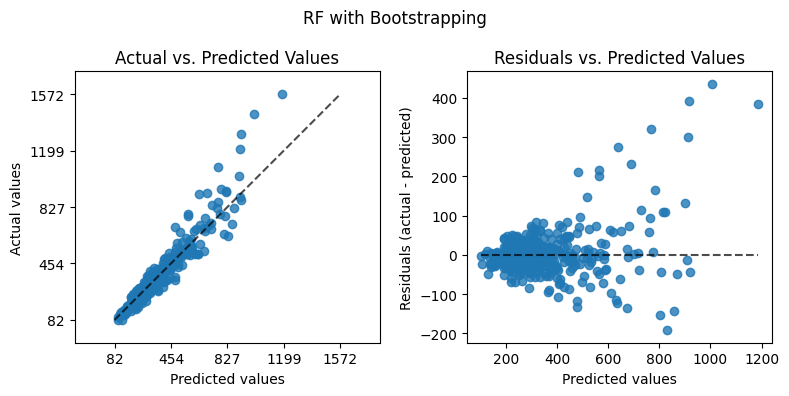

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,190.769852
1,Chevrolet_Malibu_2,258.092840,220.642885
2,Chevrolet_Malibu_3,424.794793,343.942257
3,Chevrolet_Malibu_4,290.436514,242.442114
4,Chevrolet_Malibu_5,420.078974,364.382577
...,...,...,...
389,Silverado3_9,681.561616,721.064544
390,Silverado3_10,515.137124,557.290545
391,Silverado3_11,417.693284,406.868237
392,Silverado3_12,466.661660,489.530894


In [31]:
# performance plots
ploting(output)

# Homogeneous Interval Non Overlapping Multivariate Tree

In [32]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
interval_size=30
aggregation_var="Duration"

time_variable = "row_in_sub_trip"
min_samples_split=30

y="FuelRate"
y_type= "functional"
y_summary = "sum"
y_var="FuelRate"
X_critical=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_functional=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_scalar=["Temperature","VehicleAge","EngineSize","VehicleWeight","Class"]
X_common_summary_list = ["sum"]
X_specific_summary_list=[["Duration","sum"],["Distance","sum"],["VehicleSpeed","zero_portion"],["Acceleration","positive_portion"],["Slope","positive_portion"]]
#,["Slope","zero_portion"],["EngineSpeed","zero_portion"],["Acceleration","zero_portion"]

aggregation_type="critical_interval_noa_multi_covariate"
step_size=15

test_seperation_method='subject_wise'
test_portion=0
test_num=1
group_num=0

prediction_model= "RF"
n_splits=5

In [ ]:
# prepare the whitened and weighted data for multivariate tree which will detect the homogenous intervals

start_times = time.time()
whitened_df= whiten_multivariate_targets(
    data,
    X_critical,
    y_var,
    subjects,
    parent_subjects,
    eps=1e-6,
    effect="corr2",                # {"vimp", "corr", "corr2", None}
    gamma=1.0,
    weight_norm="sum",           # {"sum", "mean", None}
    min_weight=1e-8,
    n_estimators=200,
    random_state=10,
    return_transform=False,
)
print("--- %s seconds ---" % (time.time() - start_times))

In [33]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_times = time.time()
min_samples_split=2
min_samples_leafs =  [5]

for min_samples_leaf in min_samples_leafs:
  print("min_samples_leaf: ",min_samples_split)
  start_time = time.time()
  new_data=data_prep(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
  avg_agg_size = round(new_data["agg_size"].mean(),2)
  print("avg_agg_size: ",avg_agg_size)
# train test division

  X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,parent_subjects, y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0, test_num=1, group_num=0)

#hyper parameter tuning (5-fold cv)

  best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

  output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)
#output.to_csv('/content/drive/My Drive/output.csv', index=False)
# performance

  MSE,MAE,MBE,MAPE,R2sq,PREDvar = performance(output)
  print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_times))


min_samples_leaf:  5
avg_agg_size:  6.12
With RFRegressor, Mean absolute error:  35.0 Mean absolute percentage error:  9.2%
--- 1621.4748828411102 seconds ---
--- 1621.4753897190094 seconds ---


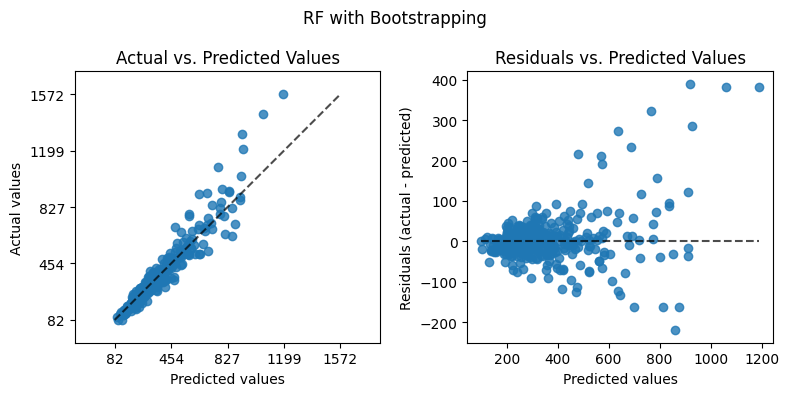

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,199.431110
1,Chevrolet_Malibu_2,258.092840,226.691666
2,Chevrolet_Malibu_3,424.794793,355.273306
3,Chevrolet_Malibu_4,290.436514,251.203197
4,Chevrolet_Malibu_5,420.078974,373.497428
...,...,...,...
389,Silverado3_9,681.561616,723.501289
390,Silverado3_10,515.137124,562.723446
391,Silverado3_11,417.693284,394.003834
392,Silverado3_12,466.661660,480.958296


In [26]:
# best performance plots
ploting(output)

# Homogeneous Interval Overlapping per Variable Tree

In [37]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
interval_size=30
aggregation_var="Duration"

time_variable = "row_in_sub_trip"
min_samples_split=30


y="FuelRate"
y_type= "functional"
y_summary = "sum"
y_var="FuelRate"
X_critical=["EngineSpeed","Acceleration","Slope"]
#,"VehicleSpeed"
X_functional=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_scalar=["Temperature","VehicleAge","EngineSize","VehicleWeight"]
#"VehicleBrandCode",
X_common_summary_list = ["sum"]
X_specific_summary_list=[["Duration","sum"],["Distance","sum"],["VehicleSpeed","zero_portion"],["Acceleration","positive_portion"],["Slope","positive_portion"]]

aggregation_type="critical_interval_oa_per_covariate"
step_size=15

test_seperation_method='subject_wise'
test_portion=0
test_num=1
group_num=0

prediction_model= "RF"
n_splits=5

In [38]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_times = time.time()
min_samples_leaf=1
min_samples_splits =  [30]

for min_samples_split in min_samples_splits:
  print("min_samples_split: ",min_samples_split)
  start_time = time.time()
  new_data=data_prep(data,time_variable,min_samples_split,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)
  avg_agg_size = round(new_data["agg_size"].mean(),2)
  print("avg_agg_size: ",avg_agg_size)
# train test division

  X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,parent_subjects, y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0, test_num=1, group_num=0)

#hyper parameter tuning (5-fold cv)

  best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

  output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)
#output.to_csv('/content/drive/My Drive/output.csv', index=False)
# performance

  MAE,MAPE = performance(output)
  print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_times))


min_samples_split:  30
avg_agg_size:  14.87
With RFRegressor, Mean absolute error:  65.4 Mean absolute percentage error:  9.7%
--- 1547.26646900177 seconds ---
--- 1547.2670314311981 seconds ---


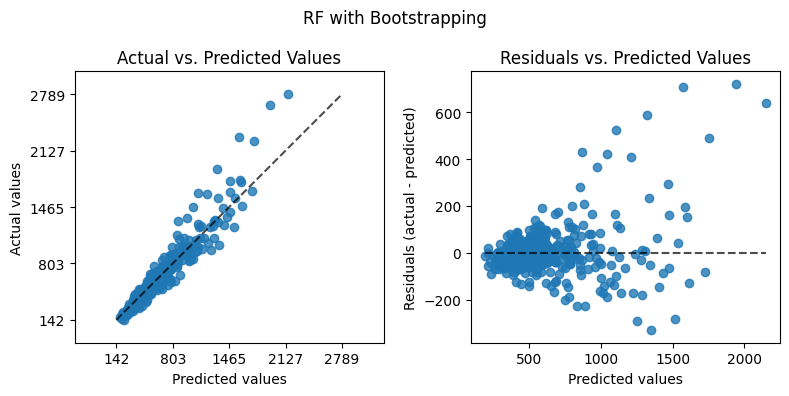

,subject,true,pred
0,Chevrolet_Malibu_1,414.209007,367.596215
1,Chevrolet_Malibu_2,467.651330,435.529076
2,Chevrolet_Malibu_3,686.311986,573.236690
3,Chevrolet_Malibu_4,493.855606,432.705684
4,Chevrolet_Malibu_5,764.986727,683.895831
...,...,...,...
389,Silverado3_9,1259.397298,1405.411286
390,Silverado3_10,952.295379,1089.803687
391,Silverado3_11,681.433119,687.741575
392,Silverado3_12,742.893615,777.080083


In [39]:
# performance plots
ploting(output)

# Non-Overlapping TA WITH Vehicle variables

In [42]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
interval_size=15
aggregation_var="Duration"
time_variable = "row_in_sub_trip"

min_samples_split=2
min_samples_leaf=1

y="FuelRate"
y_type= "functional"
y_summary = "sum"
y_var="FuelRate"
X_critical=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_functional=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_scalar=["Temperature","VehicleAge","EngineSize","VehicleWeight","Class"]
X_common_summary_list = ["sum"]
X_specific_summary_list=[["Duration","sum"],["Distance","sum"],["VehicleSpeed","zero_portion"],["Acceleration","positive_portion"],["Slope","positive_portion"]]
#,["Slope","zero_portion"],["EngineSpeed","zero_portion"],["Acceleration","zero_portion"]

aggregation_type="non_overlapping"
step_size=0

test_seperation_method='subject_wise'
test_portion=0
test_num=1
group_num=0

prediction_model= "RF"
n_splits=5

In [43]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_times = time.time()

interval_sizes = [38]

for interval_size in interval_sizes:
  print("interval_size: ",interval_size)
  start_time = time.time()
  new_data=data_prep(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)

# train test division

  X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,parent_subjects,y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0, test_num=1, group_num=0)

#hyper parameter tuning (5-fold cv)

  best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

  output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)

# performance

  MAE,MAPE = performance(output)
  print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_times))

interval_size:  38
Mean absolute error:  38.9 Mean absolute percentage error:  10.2%
--- 843.433527469635 seconds ---
--- 843.4340505599976 seconds ---


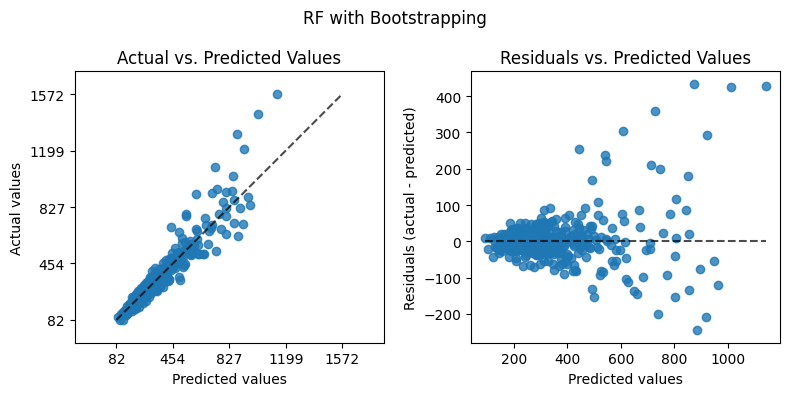

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,197.548164
1,Chevrolet_Malibu_2,258.092840,230.984348
2,Chevrolet_Malibu_3,424.794793,333.751699
3,Chevrolet_Malibu_4,290.436514,241.008931
4,Chevrolet_Malibu_5,420.078974,359.356532
...,...,...,...
389,Silverado3_9,681.561616,774.347300
390,Silverado3_10,515.137124,619.783752
391,Silverado3_11,417.693284,413.796213
392,Silverado3_12,466.661660,485.001188


In [42]:
#performance plots
ploting(output)

# Overlapping TA WITH Vehicle variables

In [37]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
aggregation_var="Duration"
time_variable = "row_in_sub_trip"

min_samples_split=2
min_samples_leaf=1

y="FuelRate"
y_type= "functional"
y_summary = "sum"
y_var="FuelRate"
X_critical=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_functional=["EngineSpeed","Acceleration","Slope","VehicleSpeed"]
X_scalar=["Temperature","VehicleAge","EngineSize","VehicleWeight","Class"]
X_common_summary_list = ["sum"]
X_specific_summary_list=[["Duration","sum"],["Distance","sum"],["VehicleSpeed","zero_portion"],["Acceleration","positive_portion"],["Slope","positive_portion"]]
#,["Slope","zero_portion"],["EngineSpeed","zero_portion"],["Acceleration","zero_portion"]

aggregation_type="overlapping"
step_size=1

test_seperation_method='subject_wise'
test_portion=0
test_num=1
group_num=0

prediction_model= "RF"
n_splits=5

In [38]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_times = time.time()

interval_sizes = [38]

for interval_size in interval_sizes:
  print("interval_size: ",interval_size)
  start_time = time.time()
  new_data=data_prep(data,time_variable,min_samples_split,min_samples_leaf,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_critical,X_common_summary_list,X_scalar,X_specific_summary_list)

# train test division

  X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,parent_subjects,y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0, test_num=1, group_num=0)

#hyper parameter tuning (5-fold cv)

  best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

  output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)

# performance

  MAE,MAPE = performance(output)
  print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_times))

interval_size:  38
Mean absolute error:  37.8 Mean absolute percentage error:  9.8%
--- 27352.324941635132 seconds ---
--- 27352.325366020203 seconds ---


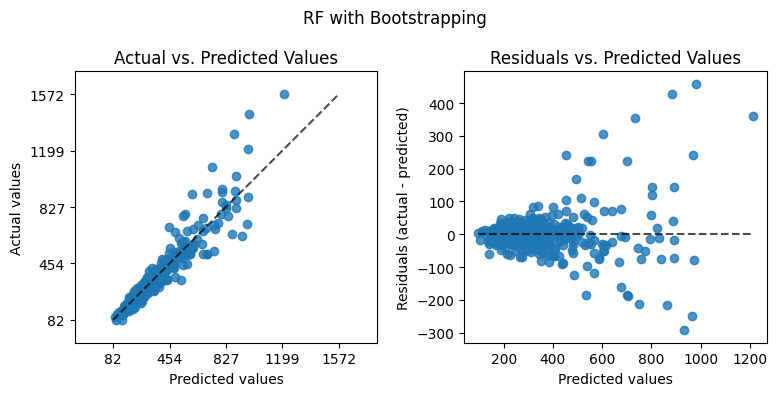

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,210.474207
0,Chevrolet_Malibu_2,258.092840,243.413487
0,Chevrolet_Malibu_3,424.794793,338.947096
0,Chevrolet_Malibu_4,290.436514,242.344790
0,Chevrolet_Malibu_5,420.078974,366.391305
...,...,...,...
0,Silverado3_9,681.561616,756.570655
0,Silverado3_10,515.137124,589.078264
0,Silverado3_11,417.693284,400.401926
0,Silverado3_12,466.661660,462.543828


In [40]:
#performance plots
ploting(output)

# Benchmark per second WITH Vehicle variables

In [44]:
# import data and define parameters

data = pd.read_csv("data_subtrip.csv")

subjects="sub_trip"
parent_subjects= "Trip"
prediction_model='RF'
n_splits=5

response = "FuelRate"
predictors=["Class","EngineSpeed","Acceleration","Slope","VehicleSpeed","Temperature","VehicleAge","EngineSize","VehicleWeight","Distance","PositiveAcceleration","PositiveSlope","Idling"]
#,"ZeroAcceleration","ZeroSlope","ZeroEngineSpeed"
start_time = time.time()
#subject list creation
#test_num=1
chunk_size=1  # if 1 trip at a time
#group_number=10   # if we have lots of sub trips we do a 10-fold
subject_list_raw = data[parent_subjects].unique()
subject_list = [subject_list_raw[i:i + chunk_size] for i in range(0, len(subject_list_raw), chunk_size)] # if 1 trip at a time
#subject_list = np.array_split(subject_list_raw, group_number)  # if we have lots of sub trips we do a 10-fold
# train test division
X_train=[]
y_train=[]
X_test_blocks=[]
y_test_blocks=[]
X_test_TT=[]
y_test_TT=[]
Duration_test_TT=[]
Subject_test_TT=[]
for subject in subject_list:
  subject_list_raw = data[parent_subjects].unique()
  non_subject=[x for x in subject_list_raw if x not in subject]
  #train
  data_train=data[data[parent_subjects].isin(non_subject)]
  data_train.reset_index(drop=True, inplace=True)
  sub_X_train = data_train[predictors]
  sub_y_train= data_train[response]
  #list=data_train[subjects].unique()
  #print(list)
  #test
  data_test_TT=[]
  sub_X_test_TT=[]
  sub_y_test_TT =[]
  sub_Duration_test_TT=[]
  sub_Subject_test_TT=[]
  data_test_block=data[data[parent_subjects].isin(subject)]
  subject_list_2 = data_test_block[subjects].unique()
  for subject2 in subject_list_2:
    data_subject2 = data[(data[subjects]==subject2)]
    data_subject2['agg_size']=1
    data_subject2=data_subject2.reset_index(drop=True, inplace=False)
    data_subject2_X=data_subject2[predictors]
    data_subject2_y=data_subject2[response]
    data_subject2_Duration=data_subject2['agg_size']
    data_subject2_Subject=data_subject2[subjects]
    data_test_TT.append(data_subject2)
    sub_X_test_TT.append(data_subject2_X)
    sub_y_test_TT.append(data_subject2_y)
    sub_Duration_test_TT.append(data_subject2_Duration)
    sub_Subject_test_TT.append(data_subject2_Subject)
 # list=data_test_TT[subjects].unique()
 # print(list)

  X_train.append(sub_X_train)
  y_train.append(sub_y_train)
  X_test_TT.append(sub_X_test_TT)
  y_test_TT.append(sub_y_test_TT)
  Duration_test_TT.append(sub_Duration_test_TT)
  Subject_test_TT.append(sub_Subject_test_TT)

print("--- %s seconds ---" % (time.time() - start_time))


--- 9.534167528152466 seconds ---


In [45]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

# data preparation (creating intervals and summarizing data (X and y) for each interval)

start_time = time.time()

#new_data=data_prep(data,time_variable,min_samples_split,subjects,y,y_type,y_summary,aggregation_type,step_size,aggregation_var,interval_size,X_functional,X_common_summary_list,X_scalar,X_specific_summary_list)

# train test division

#X_train,y_train,X_test_blocks,y_test_blocks,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT = test_train_split(new_data,subjects,y,y_type,y_summary,X_scalar,X_functional,X_common_summary_list,X_specific_summary_list,aggregation_type,test_seperation_method='subject_wise', test_portion=0.20, test_num=1, group_num=5)

#hyper parameter tuning (5-fold cv)

best_model = fold_cv(X_train, y_train,prediction_model,n_splits)

# make predictions and calculate accuracy

output = predictions_sum(best_model,X_test_TT,y_test_TT,Duration_test_TT,Subject_test_TT)

# performance

MAE,MAPE = performance(output)
print("--- %s seconds ---" % (time.time() - start_time))

Mean absolute error:  40.6 Mean absolute percentage error:  11.2%
--- 6725.266180753708 seconds ---


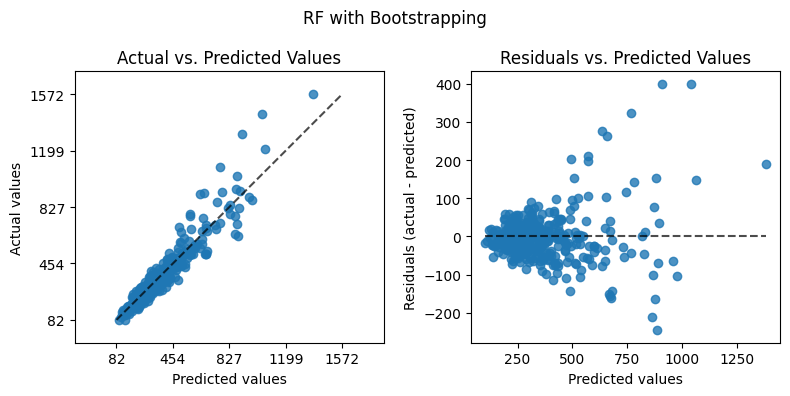

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,187.391162
0,Chevrolet_Malibu_2,258.092840,217.961884
0,Chevrolet_Malibu_3,424.794793,345.205829
0,Chevrolet_Malibu_4,290.436514,241.842261
0,Chevrolet_Malibu_5,420.078974,360.233772
...,...,...,...
0,Silverado3_9,681.561616,736.226446
0,Silverado3_10,515.137124,535.308702
0,Silverado3_11,417.693284,405.465580
0,Silverado3_12,466.661660,492.268768


In [46]:
# performance plots
ploting(output)

# Benchmark linear regression on total trip data WITH Vehicle variables

In [47]:
#define a function to summarize covariates and target variable of entire trips

def summarize_subtrips(df):
    # Base summary
    summary = df.groupby('sub_trip').agg({
        'Trip': 'first',  # Each sub_trip has a unique trip
        'Class': 'first',
        'EngineSpeed': 'mean',
        'VehicleSpeed': 'mean',
        'Acceleration': 'mean',
        'Slope': 'mean',
        'Distance': 'sum',
        'Duration': 'sum',
        'Temperature': 'mean',
        'VehicleAge': 'mean',
        'EngineSize': 'mean',
        'VehicleWeight': 'mean',
        'FuelRate': 'sum'
    }).reset_index()

    # Rename columns
    summary.columns = [
        'sub_trip', 'Trip', 'Class', 'EngineSpeed','VehicleSpeed', 'Acceleration', 'Slope',
        'TotalDistance', 'TotalDuration',
        'Temperature',
        'VehicleAge', 'EngineSize', 'VehicleWeight',
        'TotalFuelCons'
    ]

    # Calculate proportions
    proportions = df.groupby('sub_trip').apply(lambda x: pd.Series({
        'ZeroSpeedPortion': (x['VehicleSpeed'] == 0).mean(),
        'ZeroEngineSpeedPortion': (x['EngineSpeed'] == 0).mean(),
        'PositiveSlopePortion': (x['Slope'] > 0).mean(),
        'ZeroSlopePortion': (x['Slope'] == 0).mean(),
        'ZeroAccelPortion': (x['Acceleration'] == 0).mean(),
        'PositiveAccelPortion': (x['Acceleration'] > 0).mean()
    })).reset_index()

    # Merge with summary
    summary = summary.merge(proportions, on='sub_trip')

    return summary


In [48]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_time = time.time()
data = pd.read_csv("data_subtrip.csv")

data = summarize_subtrips(data)

output=pd.DataFrame()
subject_list_raw = data["Trip"].unique()
for subject in subject_list_raw:
  data_train=data[data["Trip"]!=subject]
  X_train=data_train[["Class",'EngineSpeed',"VehicleSpeed","Acceleration","Slope","TotalDistance","TotalDuration","Temperature","VehicleAge","EngineSize","VehicleWeight","ZeroSpeedPortion", "PositiveSlopePortion", "PositiveAccelPortion"]]
#, "ZeroAccelPortion","ZeroSlopePortion","ZeroEngineSpeedPortion"
  y_train=data_train["TotalFuelCons"]
  data_test=data[data["Trip"]==subject]
  X_trest=data_test[["Class",'EngineSpeed',"VehicleSpeed","Acceleration","Slope","TotalDistance","TotalDuration","Temperature","VehicleAge","EngineSize","VehicleWeight","ZeroSpeedPortion", "PositiveSlopePortion", "PositiveAccelPortion"]]
#, "ZeroAccelPortion","ZeroSlopePortion","ZeroEngineSpeedPortion"
  y_test=data_test["TotalFuelCons"]
  sub_trip=data_test["sub_trip"]
  model=LinearRegression().fit(X_train, y_train)
  y_pred=model.predict(X_trest)
  sub_output = pd.DataFrame({'subject' : sub_trip, 'true' : y_test, 'pred' : y_pred})
  output=pd.concat([output,sub_output])

print("--- %s seconds ---" % (time.time() - start_time))



--- 1.7176053524017334 seconds ---


In [49]:
# define the function to calculate performance metrics (MAE and MAPE)

def performance(output):
    y_test = output["true"]
    y_pred = output["pred"]

    MAE = mean_absolute_error(y_test, y_pred)
    MAE = round(MAE, 1)


    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    MAPE = round(MAPE * 100, 1)  # Convert to percentage
    MAPE = f"{MAPE:.1f}%"

    print(
        f"Mean absolute error: {MAE}",
        f"Mean absolute percentage error: {MAPE}"
    )

    return MAE, MAPE

In [50]:
MAE,MAPE=performance(output)

Mean absolute error: 72.0 Mean absolute percentage error: 21.6%


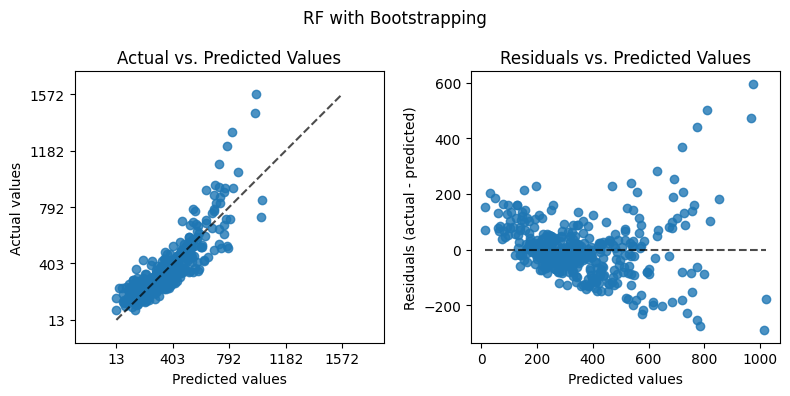

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,48.076320
1,Chevrolet_Malibu_10,366.598883,151.452942
2,Chevrolet_Malibu_2,258.092840,97.268934
3,Chevrolet_Malibu_3,424.794793,195.428614
4,Chevrolet_Malibu_4,290.436514,129.079104
...,...,...,...
389,Volkswagen_Jetta_part2_1,330.320384,217.057930
390,Volkswagen_Jetta_part2_2,279.169780,164.153032
391,Volkswagen_Jetta_part2_3,242.053777,78.773155
392,Volkswagen_Jetta_part2_4,166.290370,13.178999


In [51]:
#performance plots
ploting(output)

# Benchmark Random Forest on total trip data WITH Vehicle variables

In [52]:
#define a function to summarize covariates and target variable of entire trips

def summarize_subtrips(df):
    # Base summary
    summary = df.groupby('sub_trip').agg({
        'Trip': 'first',  # Each sub_trip has a unique trip
        'Class': 'first',
        'EngineSpeed': 'mean',
        'VehicleSpeed': 'mean',
        'Acceleration': 'mean',
        'Slope': 'mean',
        'Distance': 'sum',
        'Duration': 'sum',
        'Temperature': 'mean',
        'VehicleAge': 'mean',
        'EngineSize': 'mean',
        'VehicleWeight': 'mean',
        'FuelRate': 'sum'
    }).reset_index()

    # Rename columns
    summary.columns = [
        'sub_trip', 'Trip', 'Class', 'EngineSpeed','VehicleSpeed', 'Acceleration', 'Slope',
        'TotalDistance', 'TotalDuration',
        'Temperature',
        'VehicleAge', 'EngineSize', 'VehicleWeight',
        'TotalFuelCons'
    ]

    # Calculate proportions
    proportions = df.groupby('sub_trip').apply(lambda x: pd.Series({
        'ZeroSpeedPortion': (x['VehicleSpeed'] == 0).mean(),
        'ZeroEngineSpeedPortion': (x['EngineSpeed'] == 0).mean(),
        'PositiveSlopePortion': (x['Slope'] > 0).mean(),
        'ZeroSlopePortion': (x['Slope'] == 0).mean(),
        'ZeroAccelPortion': (x['Acceleration'] == 0).mean(),
        'PositiveAccelPortion': (x['Acceleration'] > 0).mean()
    })).reset_index()

    # Merge with summary
    summary = summary.merge(proportions, on='sub_trip')

    return summary

In [53]:
# aggregate data, seperate train, test data, apply prediction and calculate prediction performance metrics

start_time = time.time()
data = pd.read_csv("data_subtrip.csv")

data = summarize_subtrips(data)

output=pd.DataFrame()
subject_list_raw = data["Trip"].unique()
for subject in subject_list_raw:
  data_train=data[data["Trip"]!=subject]
  X_train=data_train[["Class",'EngineSpeed',"VehicleSpeed","Acceleration","Slope","TotalDistance","TotalDuration","Temperature","VehicleAge","EngineSize","VehicleWeight","ZeroSpeedPortion", "PositiveSlopePortion", "PositiveAccelPortion"]]
##, "ZeroAccelPortion","ZeroSlopePortion","ZeroEngineSpeedPortion"
  y_train=data_train["TotalFuelCons"]
  data_test=data[data["Trip"]==subject]
  X_trest=data_test[["Class",'EngineSpeed',"VehicleSpeed","Acceleration","Slope","TotalDistance","TotalDuration","Temperature","VehicleAge","EngineSize","VehicleWeight","ZeroSpeedPortion", "PositiveSlopePortion", "PositiveAccelPortion"]]
#, "ZeroAccelPortion","ZeroSlopePortion","ZeroEngineSpeedPortion"
  y_test=data_test["TotalFuelCons"]
  sub_trip=data_test["sub_trip"]
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_trest)
  sub_output = pd.DataFrame({'subject' : sub_trip, 'true' : y_test, 'pred' : y_pred})
  output=pd.concat([output,sub_output])

print("--- %s seconds ---" % (time.time() - start_time))


--- 17.842554092407227 seconds ---


In [54]:
# define the function to calculate performance metrics (MAE and MAPE)

def performance(output):
    y_test = output["true"]
    y_pred = output["pred"]


    MAE = mean_absolute_error(y_test, y_pred)
    MAE = round(MAE, 1)


    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    MAPE = round(MAPE * 100, 1)  # Convert to percentage
    MAPE = f"{MAPE:.1f}%"


    print(

        f"Mean absolute error: {MAE}",
        f"Mean absolute percentage error: {MAPE}"
    )

    return MAE, MAPE

In [55]:
MAE,MAPE=performance(output)

Mean absolute error: 58.7 Mean absolute percentage error: 15.2%


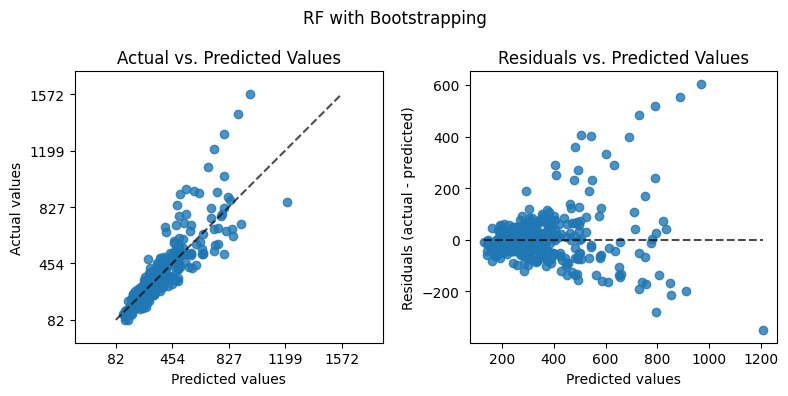

,subject,true,pred
0,Chevrolet_Malibu_1,232.079891,205.233218
1,Chevrolet_Malibu_10,366.598883,307.678130
2,Chevrolet_Malibu_2,258.092840,248.737826
3,Chevrolet_Malibu_3,424.794793,304.256131
4,Chevrolet_Malibu_4,290.436514,252.830887
...,...,...,...
389,Volkswagen_Jetta_part2_1,330.320384,335.087115
390,Volkswagen_Jetta_part2_2,279.169780,315.252209
391,Volkswagen_Jetta_part2_3,242.053777,211.511731
392,Volkswagen_Jetta_part2_4,166.290370,186.875631


In [56]:
#performance plots
ploting(output)